# Introduction
- Compare npj results to schrodingers
    - Is the discrepancy due to choice of:
        - Functional?
        - ML-architecture?
- Sam's paper seems to suggest that:
    - MACE is more efficient in terms of data set size requirements,
    - it is possible to generate data with one ML-architecture and train a model with a different ML-architecture on that data and expect similar results, and
    - produces more reliable diffusivities and densities with low seed variability for bulk-models
- Is it possible to train MACE on clusters?
    - This would perhaps allow one to use hybrid functionals
    - We note that the Schrodiger publication had long-range interactions and a different goal than we have here, but we want to see how well it works anyway
    - We should provide examples of studies that focused on neutral systems without excplicit long-range electrostatics with a reasonable degree of success to motivate this further. Just to say something.

# Results

In [16]:
from ase.io import read, iread

import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import linregress

from aseMolec import pltProps as pp
from aseMolec import anaAtoms as aa

# Colourblind friendly colours
import tol_colors as tc
cset = tc.tol_cset('bright')
plt.rc('axes', prop_cycle=plt.cycler('color', list(cset)))

fsize = 24
plt.rcParams.update({'font.size': fsize})


dynamics_path = '../publication/dynamics/'
static_path = '../publication/static_tests/'

tmap = {
    'npt_000conEC_298K':'EMC (298$\,$K)',
    'npt_033conEC_298K':'EC:EMC (3:7) (298$\,$K)',
    'npt_066conEC_298K':'EC:EMC (7:3) (298$\,$K)',
    'npt_100conEC_313K':'EC (313$\,$K)',
}

conmap = {
    '000conEC':'EMC (298$\,$K)',
    '033conEC':'EC:EMC (3:7) (298$\,$K)',
    '066conEC':'EC:EMC (7:3) (298$\,$K)',
    '100conEC':'EC (313$\,$K)',
}


In [ ]:
def get_all_thermo(tag,xyz=False):
    """This needs to be exhanged for Ioans version in order to be consistent with
    zenodo.
    """
    import glob
    thermo = {}
    if xyz:
        flist = [name for name in glob.glob(tag) if '.xyz' in name]
    else:
        flist = [name for name in glob.glob(tag) if '.thermo' in name]

    #for name in glob.glob(tag):
    #    print(name)
    #flist = z.read_dat_files(tag, ext='.thermo')
    for f in flist:
        #print(f)
        aux = os.path.basename(f)
        key = os.path.splitext(aux)[0]
        #print(aux,key)
        if xyz:
        else:
            thermo.update({key: pp.loadtxttag(f)})
    return thermo

def get_dens(tags, root_path, std=False):
    thermo = dict()
    for tag in tags:
        thermo[tag] = get_all_thermo(f'{root_path}{tag}/*.thermo')
    
    densities = dict()
    densities_std = dict()
    for i, k in enumerate(thermo):
        tag = tags[i]
        densities[tag] = {}
        densities_std[tag] = {}
        for traj_name, traj_data in thermo[k].items():
            # Collect data
            dens, dunit = traj_data['Density']['data'], traj_data['Density']['units']
            #densities[tag]['units'] = dunit
            densities[tag][traj_name] = np.mean(dens)
            densities_std[tag][traj_name] = np.std(dens)
    if std:
        return densities, densities_std, dunit
    else:
        return densities, dunit


def get_xyz(tag):
    import glob
    flist = [name for name in glob.glob(tag)]
    atoms = []
    for f in flist:
        #print(f)
        if 'xyz' in f:
            #print(f,'xyz')
            return read(f, ':')
            #atoms.append(read(f, ':'))
    return atoms

def RMSE(x,y):
    rmse = np.sqrt(np.mean((x-y)**2))
    rrmse = rmse/np.sqrt(np.mean((x-np.mean(x))**2))
    #se = (x-y)**2
    #rmse = np.mean(se)**0.5
    #rrmse = rmse/(np.mean((x-np.mean(x))**2))**0.5
    return rmse, rrmse

def get_colour(name):
    colmap = {
        'EMC (298$\,$K)':'blue',
        'EC:EMC (3:7) (298$\,$K)':'green',
        'EC:EMC (7:3) (298$\,$K)':'yellow',
        'EC (313$\,$K)':'red',
    }
    try:
        return getattr(cset, colmap[name])
    except:
        return getattr(cset, colmap[tmap[name]])

def get_average_density(dataframe, col, value):
	# Filter out the 'other' column (we either average sample or seed)
	col_set = ['Seed', 'Sample']; col_set.remove(col)
	filtered_dataframe = dataframe[dataframe[col_set[0]] == value]

	# Get statistics
	df_list = []
	for comp, comp_df in filtered_dataframe.groupby('Composition'):
		for train, train_df in comp_df.groupby('Train data'):
			mean = train_df['Avg. density'].mean()
			variance = train_df['Avg. density'].var()
			agg_col = train_df.drop(col, axis=1)
			agg_col['Avg. density'] = mean
			agg_col['Stdev.'] = variance**0.5
			df_list.append(agg_col)

	# Merge data frames and remove duplicate rows
	merged_df = pd.concat(df_list, ignore_index=True)
	clean_df = merged_df.drop_duplicates()
	return clean_df

def get_density(tags, std=False):
    # Compute average densities
    dens = dict()
    if std:
        dens, denstd, dunit = get_dens(tags, dynamics_path, std=True)
    else:
        dens, dunit = get_dens(tags, dynamics_path)

    # Collect average densities for all tags
    data = {
        'Train data':[],
        'Functional':[],
        'Seed':[],
        'Sample':[],
        'Composition':[],
        'Avg. density':[],
    }
    if std:
        data |= {'Std. density':[]}

    for tag, d in dens.items():
        data_set, functional, seed, dset_sample = tag.split('/')
        seed = int(seed[-1]); dset_sample = int(dset_sample[-1])

        # Add one instance per composition
        for i in range(4):
            data['Train data'].append(data_set)
            data['Functional'].append(functional)
            data['Seed'].append(seed)
            data['Sample'].append(dset_sample)
        
        # Add average densities for each composition
        for traj_name, avg_dens in d.items():
            comp = traj_name.split('_')[1]
            data['Composition'].append(conmap[comp])
            data['Avg. density'].append(avg_dens)
            if std:
                data['Std. density'].append(denstd[tag][traj_name])
    #for key,val in data.items():
    #    print(key, len(val))
    return pd.DataFrame(data), dunit


def diffusion_coefficient(time, msd):
  """Determines the diffusion coefficient in three dimensions
  from the slope of the MSD-curve.
  """
  res = linregress(time,msd)
  diffusion_coeff = res.slope/6 #final unit: A^2/fs
  diffusion_coeff *= 1e-5 #final unit: m^2/s
  ##D, offs = np.polyfit(t, msd, deg=1)
  ##D /= 6 #final unit: A^2/ps
  ##D *= 100 #final unit: 10^-10 m^2/s or 10^-6 cm^2/s
  return diffusion_coeff, res.stderr, res.rvalue**2


def get_slope(time, msd):
  res = linregress(time,msd)
  return res.slope, res.intercept, res.stderr

def get_start_index(time, msd, threshold=False, min_steps=0):
    if threshold:
        print(f'Using slope error thresold of: {threshold}')
        for i, t in enumerate(time):
            if i != 0:
                slope, intercept, err = get_slope(np.log(time[i:]),np.log(msd[i:]))
                if (abs(slope-1) < threshold) and (i+1 > min_steps):
                    idx = i
                    break
                else:
                    idx = None
    else:
        slopes = []
        for i, t in enumerate(time):
            if i != 0:
                slope, intercept, err = get_slope(np.log(time[i:]),np.log(msd[i:]))
                slopes.append(abs(slope-1))
        slopes = np.array(slopes)
        slopes[slopes == np.nan] = 100
        #idx = np.argmin(slopes[~np.isnan(slopes)])
        idx = np.argmin(slopes)
    return idx


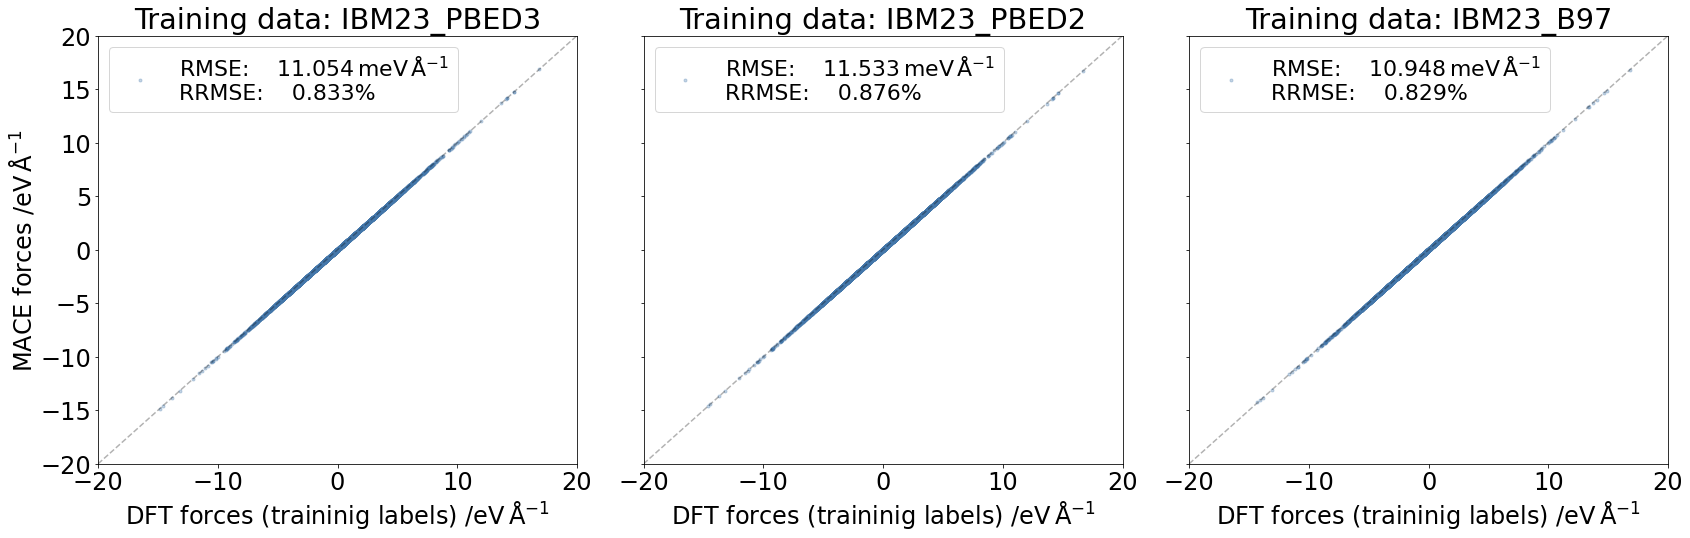

In [24]:
tags = [
    'IBM23/PBED3/SEED1/DSET1',
    'IBM23/PBED2/SEED1/DSET1',
    'IBM23/B97/SEED1/DSET1',
] # These tags needs to be adjusted to be compliant with zenodo

# Obtain data and store to dicts
xyz = dict()
for tag in tags:
    xyz[tag] = get_xyz(f'{static_path}/{tag}/*') # Argument should be 'tag' to be consistent with zenodo


fig, axs = plt.subplots(1,len(tags), figsize=(8*len(tags), 8*1), sharex=True, sharey=True)
for i, k in enumerate(xyz):
    tag = tags[i]
    atoms = xyz[k]
    data_set, functional, seed, dset_sample = tag.split('/')
    
    # Obtain forces and errors
    ## reference
    ref_forces = [a.arrays['forces'] for a in atoms if 'forces' in a.arrays.keys()]
    ref_forces = np.concatenate(ref_forces).flatten()

    ## mace
    mace_forces = [a.arrays['MACE_forces'] for a in atoms if 'forces' in a.arrays.keys()]
    mace_forces = np.concatenate(mace_forces).flatten()
    rmse, rrmse = RMSE(ref_forces, mace_forces)

    # Plot correlations
    axs[i].set_title(f'Training data: {data_set}_{functional}')
    axs[i].plot(ref_forces, mace_forces, '.', label=f'RMSE:    {rmse*1e3:.3f}$\\,$meV$\,$Å$^{{-1}}$\nRRMSE:    {rrmse*100:.3f}%', alpha=0.3)
    axs[i].legend(loc='upper left', numpoints=1, fontsize=fsize-2)

    # Plot settings
    axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.3)
    axs[i].set_xlabel('DFT forces (traininig labels) /eV$\,$Å$^{-1}$')
    axs[i].set_xlim([-20,20])
    axs[i].set_ylim([-20,20])
    if i == 0: axs[i].set_ylabel('MACE forces /eV$\,$Å$^{-1}$')
    
    plt.tight_layout()

In [26]:
tags = [
    'IBM23/PBED3/SEED1/DSET1',
    'IBM23/PBED2/SEED1/DSET1',
    'IBM23/B97/SEED1/DSET1',
] # These tags needs to be adjusted to be compliant with zenodo

xyz = dict()
for tag in tags:
    xyz[tag] = get_all_thermo(f'{dynamics_path}{tag}/*', xyz=True) # Argument should be 'tag' to be consistent with zenodo

AssertionError: 

In [8]:

def transcribe_path(path):
    fname = path.split('/')[-1]
    model = path.split('/')[0]
    if '-' in fname:
        recomp = True
        base, _ = fname.split('-')
    else:
        recomp = False
        base, _ = fname.split('.')
    ensemble, config, temp = base.split('_')
    return fname, ensemble, config, temp, recomp, model






step_lenghts = []
for path, atoms in xyz.items():
    #fname, ensemble, config, temp, recomp, model = transcribe_path(path)
    print(atoms)
    x = [a.positions for a in atoms]
    mdx = [np.mean(x) for x in np.diff(x)]
    step_lenghts.append(np.mean(mdx))


print(step_lenghts)
print(np.mean(step_lenghts))


"""
axs[0].set_title('Traj: SDN22NQ_B97_'+'_'.join([ensemble, config, temp]))
axs[0].set_xlabel('SDN22NQ_B97 forces /eV$\,$Å$^{-1}$')
axs[0].set_ylabel('IBM23_B97 forces /eV$\,$Å$^{-1}$')
axs[0].plot(SDN22NQ, IBM23, '.', label=f'RMSE:    {rmse*1e3:.3f}$\,$meV\nRRMSE:  {rrmse:.3f}$\,$meV', alpha=0.3)
axs[0].plot([0, 1], [0, 1], 'k--', transform=axs[0].transAxes, alpha=0.3)
axs[0].legend()

for path, atoms in xyz2.items():
    fname, ensemble, config, temp, recomp, model = transcribe_path(path)
    if recomp:
        #IBM23 = np.concatenate([a.arrays['forces'].flatten() for a in atoms])
        SDN22NQ = np.concatenate([a.arrays['forces'].flatten() for a in atoms])
    else:
        #SDN22NQ = np.concatenate([a.arrays['forces'].flatten() for a in atoms])
        IBM23 = np.concatenate([a.arrays['forces'].flatten() for a in atoms])
rmse, rrmse = RMSE(IBM23, SDN22NQ)

axs[1].set_title('Traj: IBM23_B97_'+'_'.join([ensemble, config, temp]))
axs[1].set_xlabel('IBM23_B97 forces /eV$\,$Å$^{-1}$')
axs[1].set_ylabel('SDN22NQ_B97 forces /eV$\,$Å$^{-1}$')
axs[1].plot(IBM23, SDN22NQ, '.', label=f'RMSE:    {rmse*1e3:.3f}$\,$meV\nRRMSE:  {rrmse:.3f}$\,$meV', alpha=0.3)
axs[1].plot([0, 1], [0, 1], 'k--', transform=axs[1].transAxes, alpha=0.3)
axs[1].legend()
"""


{}
{}
[nan, nan]
nan


/home/viktor/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/viktor/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


"\naxs[0].set_title('Traj: SDN22NQ_B97_'+'_'.join([ensemble, config, temp]))\naxs[0].set_xlabel('SDN22NQ_B97 forces /eV$\\,$Å$^{-1}$')\naxs[0].set_ylabel('IBM23_B97 forces /eV$\\,$Å$^{-1}$')\naxs[0].plot(SDN22NQ, IBM23, '.', label=f'RMSE:    {rmse*1e3:.3f}$\\,$meV\nRRMSE:  {rrmse:.3f}$\\,$meV', alpha=0.3)\naxs[0].plot([0, 1], [0, 1], 'k--', transform=axs[0].transAxes, alpha=0.3)\naxs[0].legend()\n\nfor path, atoms in xyz2.items():\n    fname, ensemble, config, temp, recomp, model = transcribe_path(path)\n    if recomp:\n        #IBM23 = np.concatenate([a.arrays['forces'].flatten() for a in atoms])\n        SDN22NQ = np.concatenate([a.arrays['forces'].flatten() for a in atoms])\n    else:\n        #SDN22NQ = np.concatenate([a.arrays['forces'].flatten() for a in atoms])\n        IBM23 = np.concatenate([a.arrays['forces'].flatten() for a in atoms])\nrmse, rrmse = RMSE(IBM23, SDN22NQ)\n\naxs[1].set_title('Traj: IBM23_B97_'+'_'.join([ensemble, config, temp]))\naxs[1].set_xlabel('IBM23_B97 f

ValueError: need at least one array to concatenate

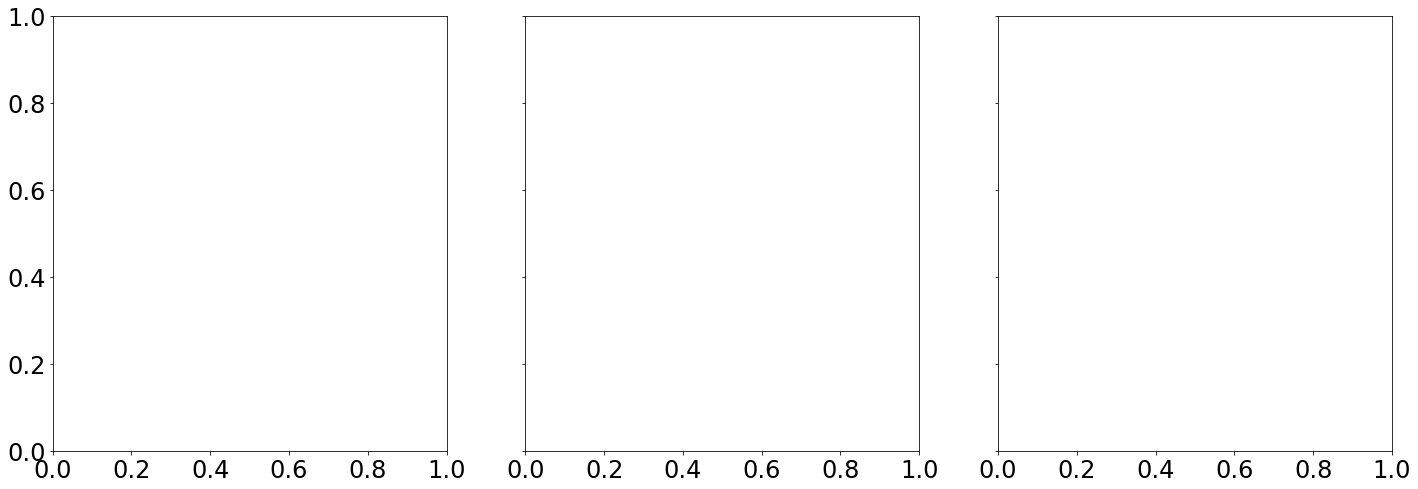

In [9]:
fig, axs = plt.subplots(1,len(tags), figsize=(8*len(tags), 8*1), sharex=True, sharey=True)
for i, k in enumerate(xyz):
    tag = tags[i]
    atoms = xyz[k]
    data_set, functional, seed, dset_sample = tag.split('/')
    
    # Obtain forces and errors
    ## reference
    ref_forces = [a.arrays['forces'] for a in atoms if 'forces' in a.arrays.keys()]
    ref_forces = np.concatenate(ref_forces).flatten()

    ## mace
    mace_forces = [a.arrays['MACE_forces'] for a in atoms if 'forces' in a.arrays.keys()]
    mace_forces = np.concatenate(mace_forces).flatten()
    rmse, rrmse = RMSE(ref_forces, mace_forces)

    # Plot correlations
    axs[i].set_title(f'Training data: {data_set}_{functional}')
    axs[i].plot(ref_forces, mace_forces, '.', label=f'RMSE:    {rmse*1e3:.3f}$\\,$meV$\,$Å$^{{-1}}$\nRRMSE:    {rrmse*100:.3f}%', alpha=0.3)
    axs[i].legend(loc='upper left', numpoints=1, fontsize=fsize-2)

    # Plot settings
    axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.3)
    axs[i].set_xlabel('DFT forces (traininig labels) /eV$\,$Å$^{-1}$')
    axs[i].set_xlim([-20,20])
    axs[i].set_ylim([-20,20])
    if i == 0: axs[i].set_ylabel('MACE forces /eV$\,$Å$^{-1}$')
    
    plt.tight_layout()

In [ ]:
tags = [
    'IBM23/PBED3/SEED1/DSET1',
    'IBM23/PBED2/SEED1/DSET1',
    'IBM23/B97/SEED1/DSET1',
] # These tags needs to be adjusted to be compliant with zenodo

# Obtain data and store to dicts
thermo = dict()
for tag in tags:
    thermo[tag] = get_all_thermo(f'{dynamics_path}{tag}/*.thermo') # Argument should be 'tag' to be consistent with zenodo

fig, axs = plt.subplots(2,len(tags), figsize=(10*len(tags), 8*2), sharex=True, sharey='row')
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for traj_name, traj_data in thermo[k].items():
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        dens, dunit = traj_data['Density']['data'], traj_data['Density']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']

        # Plot density
        axs[0,i].set_ylim([0.8, 1.5])
        if i == 0: axs[0,i].set_ylabel(f'Density /{dunit}')
        axs[0,i].plot(time,dens, label=tmap[traj_name], color=get_colour(traj_name))

        # Plot MSD
        axs[1,i].set_ylim([0, 1400])
        if i == 0: axs[1,i].set_ylabel(f'MSD /{munit}')
        axs[1,i].plot(time,msd, label=tmap[traj_name], color=get_colour(traj_name))

        # Shared plot setings
        axs[0,i].set_title(f'{data_set}_{functional}')
        axs[1,i].set_xlabel(f'Time /{tunit}')
axs[-1,-1].legend(loc='upper left')

In [ ]:
part1_df, dunit = get_density(tags, std=True)
part1_df

In [ ]:
order = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

# Pivot tables for plotting
## Focus averages
avg_pivot_df = part1_df.pivot(
	index='Functional',
	columns='Composition',
	values='Avg. density',
).sort_index(axis=0,ascending=False)[order]

std_pivot_df = part1_df.pivot(
	index='Functional',
	columns='Composition',
	values='Std. density',
).sort_index(axis=0,ascending=False)[order]

# Plot data
fig, ax = plt.subplots(figsize=(10*1,8*1))
#fig.suptitle('Data set size variability for different molecular compositions')
#axs.set_title('Committee error w.r.t data set sample (seed 1)')
avg_pivot_df.plot.bar(
	ylim=[0.8,1.5],
	ylabel=f'Avg. density /{dunit}',
	rot=0,
	color=[get_colour(o) for o in order],
	#yerr=std_pivot_df,
	#capsize=3,
	#figsize=(6,5),
	#legend=False,
	ax=ax,
)


bars = [patch for patch in ax.patches]

# Prepare labels: "value ± error"
labels = [f'{val:.3f} $\\pm$ {err:.3f}' for val, err in zip(part1_df['Avg. density'], part1_df['Std. density'])]

# Add the custom labels using ax.text (or bar_label if you're sure it's safe)
for bar, label in zip(bars, labels):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.3,
        label,
        ha='center',
        va='bottom',
		fontsize=8,
    )

ax.legend(loc='upper left')
ax.grid(axis='y', alpha=0.3)

In [ ]:
def functional_density(df, functional, composition):
    comp_mask = df['Composition'] == composition
    func_mask = df['Functional'] == functional
    selection = df[comp_mask & func_mask]['Avg. density']
    #return round(selection.iloc[0], precision)
    return selection.iloc[0]


configs = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

data = {
    'Functional pair':['\PBE{2} and \PBE{3}', '\PBE{2} and \BNS', '\PBE{3} and \BNS'],
}

for config in configs:
    PBED2_dens = functional_density(part1_df, 'PBED2', config)
    PBED3_dens = functional_density(part1_df, 'PBED3', config)
    B97D3_dens = functional_density(part1_df, 'B97', config)
    data[config] = [abs(PBED2_dens-PBED3_dens),abs(PBED2_dens-B97D3_dens),abs(PBED3_dens-B97D3_dens)]
    print(config)
    print(f'PBED2-PBED3 diff.: {abs(PBED2_dens-PBED3_dens):.4f} g/mL')
    print(f'PBED2-B97D3 diff.: {abs(PBED2_dens-B97D3_dens):.4f} g/mL')
    print(f'PBED3-B97D3 diff.: {abs(PBED3_dens-B97D3_dens):.4f} g/mL\n')

dens_df = pd.DataFrame(data).round(decimals=3)
#dens_df['Avg. error'] = dens_df.sum(axis=1, numeric_only=True)/len(dens_df.columns)
#dens_df
print(dens_df.to_latex(index=False))

In [ ]:
part1_df['Diff. start time /ns'].iloc[0]

In [ ]:
fig, axs = plt.subplots(1,len(tags), figsize=(10*len(tags), 8*1), sharey=True)
diff_coeffs = []
diff_errs = []
diff_r2 = []
diff_starts = []
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for j, (traj_name, traj_data) in enumerate(thermo[k].items()):
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']
        
        idx = get_start_index(time,msd,threshold=1e-3, min_steps=5e3)
        if idx != None:   
            D, err, r2 = diffusion_coefficient(time[idx:],msd[idx:])
            diff_coeffs.append(D)
            diff_errs.append(err)
            diff_r2.append(r2)
            print(idx, len(time), err, r2)
            diff_starts.append(idx)
            axs[i].axvline(time[idx], 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        else:
            diff_coeffs.append(np.nan)
            diff_errs.append(np.nan)
            diff_starts.append(np.nan)
        

        
        # Plot MSD
        axs[i].set_ylim([0, 1400])
        if i == 0: axs[i].set_ylabel(f'MSD /{munit}')
        axs[i].plot(time,msd, label=tmap[traj_name], color=get_colour(traj_name))

        # Shared plot setings
        axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.1)
        axs[i].set_title(f'{data_set}_{functional}')
        axs[i].set_xscale('log'); axs[i].set_yscale('log')
        axs[i].set_xlabel(f'Time /{tunit}')

    axs[i].grid(axis='x', alpha=0.3)
        
axs[-1].legend(loc='upper left')
print(diff_coeffs, diff_errs)

for d,e in zip(diff_coeffs, diff_errs):
    print(f'Diffusion coefficient: {d*1e10:.2e} 1e-10 m^2/s , fitting error: {e:.2e}')

In [ ]:
mass = {}

tags = [
    'IBM23/PBED3/SEED1/DSET1',
    'IBM23/PBED2/SEED1/DSET1',
    'IBM23/B97/SEED1/DSET1',
] # These tags needs to be adjusted to be compliant with zenodo


def get_all_thermo(tag,xyz=False):
    """This needs to be exhanged for Ioans version in order to be consistent with
    zenodo.
    """
    import glob
    thermo = {}
    if xyz:
        flist = [name for name in glob.glob(tag) if '.xyz' in name]
    else:
        flist = [name for name in glob.glob(tag) if '.thermo' in name]
    flist = [name for name in glob.glob(tag)]

    print(flist)
    #for name in glob.glob(tag):
    #    print(name)
    #flist = z.read_dat_files(tag, ext='.thermo')
    for f in flist:
        #print(f)
        aux = os.path.basename(f)
        key = os.path.splitext(aux)[0]
        #print(aux,key)
        thermo.update({key: pp.loadtxttag(f)})
    return thermo

# Obtain data and store to dicts
xyz = dict()
for tag in tags:
    xyz[tag] = get_all_thermo(f'{dynamics_path}/{tag}/', xyz=False) # Argument should be 'tag' to be consistent with zenodo
    #print(xyz[tag])

"""
for i, k in enumerate(xyz):
    tag = tags[i]
    atoms = xyz[k]
    data_set, functional, seed, dset_sample = tag.split('/')
    #print(tag)
    print(k)
    # Obtain forces and errors
    ## reference
    #ref_forces = [a.arrays['forces'] for a in atoms if 'forces' in a.arrays.keys()]
    #ref_forces = np.concatenate(ref_forces).flatten()


"""


In [ ]:
def fsize_correction(D, rho, conf):
    eta = {
        'EMC (298$\,$K)':0.6800845267730224,
        'EC:EMC (3:7) (298$\,$K)':0.7719130364542757, 
        'EC:EMC (7:3) (298$\,$K)':1.7815471472277649,
        'EC (313$\,$K)':1.8962203533821365,
    } # Pa*s
    mass = {
        'EMC (298$\,$K)':,
        'EC:EMC (3:7) (298$\,$K)':, 
        'EC:EMC (7:3) (298$\,$K)':,
        'EC (313$\,$K)':,
    }
    xi = 2.837298
    V = mass[conf]/rho*1e6 # m3
    L = V**(1/3) # m
    return ase.units.kB*T*xi/(6*np.pi*eta[conf]*L)

In [ ]:
try:
    part1_df = pd.read_pickle("./func_res.pkl")
except:
    part1_df, dunit = get_density(tags)
    part1_df['Diffusion coefficient'] = [d*1e9 for d in diff_coeffs] # 1e-5 cm2/s
    #df['Corr. diffusion coefficient'] = [fsize_correction(D,r) for D,r in df[['Diffusion coefficient', 'Avg. density']]] # 1e-5 cm2/s
    part1_df['Diff. fit error'] = diff_errs
    part1_df['Diff. r2'] = diff_r2
    part1_df['Diff. start time /ns'] = [time[s]*1e-6 for s in diff_starts]
    pd.to_pickle(part1_df, "./func_res.pkl")
part1_df

In [ ]:
fig, axs = plt.subplots(1,len(tags), figsize=(10*len(tags), 8*1), sharey=True)
diff_coeffs = []
diff_errs = []
diff_r2 = []
diff_starts = []
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for j, (traj_name, traj_data) in enumerate(thermo[k].items()):
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']

        t =  part1_df['Diff. start time /ns'][4*i+j]*1e6
        axs[i].axvline(t, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        
        # Plot MSD
        axs[i].set_ylim([0, 1400])
        if i == 0: axs[i].set_ylabel(f'MSD /{munit}')
        axs[i].plot(time,msd, label=tmap[traj_name], color=get_colour(traj_name))

        # Shared plot setings
        axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.1)
        axs[i].set_title(f'{data_set}_{functional}')
        axs[i].set_xscale('log'); axs[i].set_yscale('log')
        axs[i].set_xlabel(f'Time /{tunit}')

    axs[i].grid(axis='x', alpha=0.3)
        
axs[-1].legend(loc='upper left')
print(diff_coeffs, diff_errs)

for d,e in zip(diff_coeffs, diff_errs):
    print(f'Diffusion coefficient: {d*1e10:.2e} 1e-10 m^2/s , fitting error: {e:.2e}')

In [ ]:
order = [
    'Functional',
    'Composition',
    'Avg. density',
    'Diffusion coefficient',
    'Diff. fit error',
    'Diff. start time /ns'
]

paper_part1_df = part1_df.drop('Seed', axis=1)
paper_part1_df = paper_part1_df.drop('Sample', axis=1)
#print(df.to_latex(index=False))

In [ ]:
order = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

# Pivot tables for plotting
diff_pivot_df = paper_part1_df.pivot(
	index='Functional',
	columns='Composition',
	values='Diffusion coefficient',
	#values=['Avg. density', 'Var.'],
).sort_index(axis=0,ascending=False)[order]


# Plot data
fig, ax = plt.subplots(figsize=(10*1,8*1))
ax.set_title('Uncorrected diffusion coefficients')
diff_pivot_df.plot.bar(
	ylim=[0,2.5],
	ylabel=f'Diffusion coefficient / $10^{{-5}}\\,\\text{{cm}}^2\\,\\text{{s}}^{{-1}}$',
	rot=0,
	color=[get_colour(o) for o in order],
	#yerr=err_pivot_df,
	#capsize=3,
	#figsize=(6,5),
	ax=ax,
)

ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

In [ ]:
def functional_diffusivity(df, functional, composition, unit='m'):
    comp_mask = df['Composition'] == composition
    func_mask = df['Functional'] == functional
    selection = df[comp_mask & func_mask]['Diffusion coefficient']
    if unit == 'm':
        return selection.iloc[0]
    elif unit == 'cm':
        return selection.iloc[0]/10


configs = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

data = {
    'Functional pair':['\PBE{2} and \PBE{3}', '\PBE{2} and \BNS', '\PBE{3} and \BNS'],
}

for config in configs:
    PBED2_diff = functional_diffusivity(paper_part1_df, 'PBED2', config, unit='cm')
    PBED3_diff = functional_diffusivity(paper_part1_df, 'PBED3', config, unit='cm')
    B97D3_diff = functional_diffusivity(paper_part1_df, 'B97', config, unit='cm')
    data[config] = [abs(PBED2_diff-PBED3_diff),abs(PBED2_diff-B97D3_diff),abs(PBED3_diff-B97D3_diff)]
    print(config)
    print(f'PBED2-PBED3 diff.: {abs(PBED2_diff-PBED3_diff):.4f}*1e-5 cm2/s')
    print(f'PBED2-B97D3 diff.: {abs(PBED2_diff-B97D3_diff):.4f}*1e-5 cm2/s')
    print(f'PBED3-B97D3 diff.: {abs(PBED3_diff-B97D3_diff):.4f}*1e-5 cm2/s\n')
    #print(f'PBED2-PBED3 diff.: {abs(PBED2_diff-PBED3_diff):.4f}*1e-10 m2/s')
    #print(f'PBED2-B97D3 diff.: {abs(PBED2_diff-B97D3_diff):.4f}*1e-10 m2/s')
    #print(f'PBED3-B97D3 diff.: {abs(PBED3_diff-B97D3_diff):.4f}*1e-10 m2/s\n')

diff_df = pd.DataFrame(data).round(decimals=4)
#diff_df['Avg. error'] = diff_df.sum(axis=1, numeric_only=True)/len(diff_df.columns)
print(diff_df.to_latex(index=False))

In [ ]:
df, dunit = get_density(tags)
df['Diffusion coefficient'] = [d*1e10 for d in diff_coeffs] # 1e-10 m2/s
df['Diff. fit error'] = diff_errs
df

In [ ]:
order = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

# Pivot tables for plotting
diff_pivot_df = paper_part1_df.pivot(
	index='Functional',
	columns='Composition',
	values='Diffusion coefficient',
	#values=['Avg. density', 'Var.'],
).sort_index(axis=0,ascending=False)[order]

"""
err_pivot_df = df.pivot(
	index='Functional',
	columns='Composition',
	values='Diff. fit error',
	#values=['Avg. density', 'Var.'],
).sort_index(axis=0,ascending=False)[order]
print(err_pivot_df)
"""

# Plot data
fig, ax = plt.subplots(figsize=(10*1,8*1))
ax.set_title('Uncorrected diffusion coefficients')
diff_pivot_df.plot.bar(
	ylim=[0,2.5],
	ylabel=f'Diffusion coefficient / $10^{{-10}}\\,\\text{{m}}^2\\,\\text{{s}}^{{-1}}$',
	rot=0,
	color=[get_colour(o) for o in order],
	#yerr=err_pivot_df,
	#capsize=3,
	#figsize=(6,5),
	ax=ax,
)

ax.legend(loc='upper left')
ax.grid(axis='y', alpha=0.3)

In [ ]:
tags = [
    'IBM23/PBED3/SEED1/DSET1',
    'IBM23/PBED2/SEED1/DSET1',
    'IBM23/B97/SEED1/DSET1',
] # These tags needs to be adjusted to be compliant with zenodo

fsize = 28
plt.rcParams.update({'font.size': fsize})

# Obtain data and store to dicts
thermo = dict()
for tag in tags:
    thermo[tag] = get_all_thermo(f'{dynamics_path}{tag}/*.thermo') # Argument should be 'tag' to be consistent with zenodo

fig, axs = plt.subplots(2,len(tags)+1, figsize=(10*(len(tags)+1), 8*2), sharex='col')
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for j, (traj_name, traj_data) in enumerate(thermo[k].items()):
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        dens, dunit = traj_data['Density']['data'], traj_data['Density']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']


        # Plot density
        axs[0,i].set_ylim([0.8, 1.8])
        if i == 0: axs[0,i].set_ylabel(f'Density /{dunit}')
        axs[0,i].plot(time,dens, label=tmap[traj_name], color=get_colour(traj_name))

        # Plot MSD
        axs[1,i].set_ylim([0, 1500])
        if i == 0: axs[1,i].set_ylabel(f'MSD /{munit}')
        axs[1,i].plot(time,msd, label=tmap[traj_name], color=get_colour(traj_name))

        axs[1,0].axvline(paper_part1_df['Diff. start time /ns'].iloc[j]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        axs[1,1].axvline(paper_part1_df['Diff. start time /ns'].iloc[j+4]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        axs[1,2].axvline(paper_part1_df['Diff. start time /ns'].iloc[j+8]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        #axs[1,0].axvline(time[diff_starts[j]], 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        #axs[1,1].axvline(time[diff_starts[j+4]], 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        #axs[1,2].axvline(time[diff_starts[j+8]], 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')

        # Shared plot setings
        axs[0,i].set_title(f'{data_set}_{functional}')
        axs[1,i].set_xlabel(f'Time /{tunit}')
        axs[0,i].grid(axis='y', alpha=0.3)
        axs[1,i].grid(axis='y', alpha=0.3)

#axs[-1,-1].legend(loc='upper left')

axs[0,-1].set_title('Average densities')
a0 = avg_pivot_df.plot.bar(
    ylim=[0.8,1.8],
    xlabel='',
    #ylabel=f'Avg. density /{dunit}',
    #yerr=std_pivot_df,
	#capsize=3,
    rot=0,
    color=[get_colour(o) for o in order],
    ax=axs[0,-1],
    legend=False,
)
#axs[0,-1].legend(loc='upper left', fontsize=18)
axs[0,-1].grid(axis='y', alpha=0.3)

axs[1,-1].set_title('Diffusion coefficients')
a1 = diff_pivot_df.plot.bar(
    ylim=[0,2.5],
    ylabel=f'Diffusion coefficient / $10^{{-10}}\\,\\text{{m}}^2\\,\\text{{s}}^{{-1}}$',
    rot=0,
    color=[get_colour(o) for o in order],
    ax=axs[1,-1],
    legend=False,
)


for i, (c0,c1) in enumerate(zip(a0.containers, a1.containers)):
    col_name = avg_pivot_df.columns[i]
    dens_vals = avg_pivot_df[col_name]
    dens_errs = std_pivot_df[col_name]
    dens_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(dens_vals, dens_errs)]

    axs[0,-1].bar_label(c0, rotation=90, fontsize=fsize-6, label_type='edge', padding=10, labels=dens_labels)
    axs[1,-1].bar_label(c1, rotation=90, fontsize=fsize-6, label_type='edge', fmt='%.3f', padding=10)

axs[0,0].legend(loc='upper left', fontsize=fsize-4)
axs[1,-1].grid(axis='y', alpha=0.3)

#axs[0, 1].set(yticklabels=[]); axs[0, 2].set(yticklabels=[]); axs[0, 3].set(yticklabels=[])
#axs[1, 1].set(yticklabels=[]); axs[1, 2].set(yticklabels=[])

#plt.rcParams.update({'font.size': fsize-4})
plt.tight_layout()

In [ ]:
tags = ['IBM23/B97/SEED1/DSET1', 'SDN22NQ/B97/SEED1/DSET1'] # These tags needs to be adjusted to be compliant with zenodo

# Obtain data and store to dicts
xyz = dict()
for tag in tags:
    xyz[tag] = get_xyz(f'{static_path}/{tag}/*') # Argument should be 'tag' to be consistent with zenodo

In [ ]:
fsize = 24
plt.rcParams.update({'font.size': fsize})


fig, axs = plt.subplots(1,len(tags), figsize=(8*len(tags), 8*1), sharex=True, sharey=True)
for i, k in enumerate(xyz):
    tag = tags[i]
    atoms = xyz[k]
    data_set, functional, seed, dset_sample = tag.split('/')
    
    # Obtain forces and errors
    ## reference
    ref_forces = [a.arrays['forces'] for a in atoms if 'forces' in a.arrays.keys()]
    ref_forces = np.concatenate(ref_forces).flatten()

    ## mace
    mace_forces = [a.arrays['MACE_forces'] for a in atoms if 'forces' in a.arrays.keys()]
    mace_forces = np.concatenate(mace_forces).flatten()
    rmse, rrmse = RMSE(ref_forces, mace_forces)

    # Plot correlations
    axs[i].set_title(f'Training data: {data_set}_{functional}')
    axs[i].plot(ref_forces, mace_forces, '.', label=f'RMSE:    {rmse*1e3:.3f}$\\,$meV$\,$Å$^{{-1}}$\nRRMSE:    {rrmse*100:.3f}%', alpha=0.3)
    axs[i].legend(loc='upper left', numpoints=1, fontsize=fsize-2)

    # Plot settings
    axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.3)
    axs[i].set_xlabel('DFT forces (traininig labels) /eV$\,$Å$^{-1}$')
    axs[i].set_xlim([-60,60])
    axs[i].set_ylim([-60,60])
    if i == 0: axs[i].set_ylabel('MACE forces /eV$\,$Å$^{-1}$')
    
plt.tight_layout()

In [ ]:
import math
x = 42

fig, axs = plt.subplots(1,len(tags), figsize=(8*len(tags), 8*1), sharex=True, sharey=True)
for i, k in enumerate(xyz):
    tag = tags[i]
    atoms = xyz[k]
    data_set, functional, seed, dset_sample = tag.split('/')
    
    # Obtain forces and errors
    ## reference
    ref_forces = [a.arrays['forces'] for a in atoms if 'forces' in a.arrays.keys()]
    ref_forces = np.concatenate(ref_forces).flatten()

    ## mace
    mace_forces = [a.arrays['MACE_forces'] for a in atoms if 'forces' in a.arrays.keys()]
    mace_forces = np.concatenate(mace_forces).flatten()
    rmse, rrmse = RMSE(ref_forces, mace_forces)


    # Plot correlations
    axs[i].set_title(f'Training data: {data_set}_{functional}')
    #axs[i].plot(ref_forces, abs(mace_forces-ref_forces), '.', label=f'RMSE:    {rmse*1e3:.3f}$\\,$meV$\,$Å$^{{-1}}$\nRRMSE:    {rrmse*100:.3f}%', alpha=0.3)
    axs[i].hexbin(ref_forces, abs(mace_forces-ref_forces), mincnt=1, gridsize=(int(x)*3**(1/3)))
    #axs[i].legend(loc='upper left', numpoints=1, fontsize=fsize-2)

    # Plot settings
    #axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.3)
    #axs[i].set_xlabel('DFT forces (traininig labels) /eV$\,$Å$^{-1}$')
    #axs[i].set_xlim([-60,60])
    #axs[i].set_ylim([-60,60])
    if i == 0: axs[i].set_ylabel('MACE forces /eV$\,$Å$^{-1}$')
    
    plt.tight_layout()

In [ ]:

fig, axs = plt.subplots(1,len(tags), figsize=(8*len(tags), 8*1), sharex=True, sharey=True)
for i, k in enumerate(xyz):
    tag = tags[i]
    atoms = xyz[k]
    data_set, functional, seed, dset_sample = tag.split('/')
    
    # Obtain forces and errors
    ## reference
    ref_forces = [a.arrays['forces'] for a in atoms if 'forces' in a.arrays.keys()]
    ref_forces = np.concatenate(ref_forces).flatten()

    ## mace
    mace_forces = [a.arrays['MACE_forces'] for a in atoms if 'forces' in a.arrays.keys()]
    mace_forces = np.concatenate(mace_forces).flatten()
    rmse, rrmse = RMSE(ref_forces, mace_forces)

    # Plot correlations
    axs[i].set_title(f'Training data: {data_set}_{functional}')
    axs[i].plot(ref_forces, abs(mace_forces-ref_forces), '.', label=f'RMSE:    {rmse*1e3:.3f}$\\,$meV$\,$Å$^{{-1}}$\nRRMSE:    {rrmse*100:.3f}%', alpha=0.3)
    axs[i].legend(loc='upper left', numpoints=1, fontsize=fsize-2)

    # Plot settings
    #axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.3)
    #axs[i].set_xlabel('DFT forces (traininig labels) /eV$\,$Å$^{-1}$')
    #axs[i].set_xlim([-10,10])
    #axs[i].set_ylim([-60,60])
    if i == 0: axs[i].set_ylabel('MACE forces /eV$\,$Å$^{-1}$')
    
    plt.tight_layout()

In [ ]:
from scipy.stats import gaussian_kde


fig, axs = plt.subplots(1,len(tags), figsize=(8*len(tags), 8*1), sharex=True, sharey=True)
for i, k in enumerate(xyz):
    tag = tags[i]
    atoms = xyz[k]
    data_set, functional, seed, dset_sample = tag.split('/')
    
    # Obtain forces and errors
    ## reference
    ref_forces = [a.arrays['forces'] for a in atoms if 'forces' in a.arrays.keys()]
    ref_forces = np.concatenate(ref_forces).flatten()

    ## mace
    mace_forces = [a.arrays['MACE_forces'] for a in atoms if 'forces' in a.arrays.keys()]
    mace_forces = np.concatenate(mace_forces).flatten()
    rmse, rrmse = RMSE(ref_forces, mace_forces)

    xy = np.vstack([ref_forces,mace_forces])
    z = gaussian_kde(xy, bw_method=0.1)(xy) # None -> Defaults to Scott's rule. Given the obvious unimodality of the histogram above it should not be a problem

    # Plot correlations
    axs[i].set_title(f'Training data: {data_set}_{functional}')
    #axs[i].plot(ref_forces, abs(mace_forces-ref_forces), '.', label=f'RMSE:    {rmse*1e3:.3f}$\\,$meV$\,$Å$^{{-1}}$\nRRMSE:    {rrmse*100:.3f}%', alpha=0.3)
    axs[i].scatter(ref_forces, abs(mace_forces-ref_forces), s=4, c=z, label=f'RMSE:    {rmse*1e3:.3f}$\\,$meV$\,$Å$^{{-1}}$\nRRMSE:    {rrmse*100:.3f}%', alpha=0.3)
    axs[i].legend(loc='upper left', numpoints=1, fontsize=fsize-2)

    
    # Plot settings
    #axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.3)
    #axs[i].set_xlabel('DFT forces (traininig labels) /eV$\,$Å$^{-1}$')
    #axs[i].set_xlim([-10,10])
    #axs[i].set_ylim([-60,60])
    if i == 0: axs[i].set_ylabel('MACE forces /eV$\,$Å$^{-1}$')
    
plt.tight_layout()


In [ ]:
tags = ['IBM23/B97/SEED1/DSET1', 'SDN22NQ/B97/SEED1/DSET1'] # These tags needs to be adjusted to be compliant with zenodo

# Obtain data and store to dicts
thermo = dict()
for tag in tags:
    thermo[tag] = get_all_thermo(f'{dynamics_path}{tag}/*.thermo') # Argument should be 'tag' to be consistent with zenodo

fig, axs = plt.subplots(2,2, figsize=(10*2, 8*2), sharex=True, sharey='row')
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for traj_name, traj_data in thermo[k].items():
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        dens, dunit = traj_data['Density']['data'], traj_data['Density']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']

        # Plot density
        axs[0,i].set_ylim([0.8, 1.5])
        if i == 0: axs[0,i].set_ylabel(f'Density /{dunit}')
        axs[0,i].plot(time,dens, label=tmap[traj_name], color=get_colour(traj_name))

        # Plot MSD
        axs[1,i].set_ylim([0, 1400])
        if i == 0: axs[1,i].set_ylabel(f'MSD /{munit}')
        axs[1,i].plot(time,msd, label=tmap[traj_name], color=get_colour(traj_name))

        # Shared plot setings
        axs[0,i].set_title(f'{data_set}_{functional}')
        axs[1,i].set_xlabel(f'Time /{tunit}')
axs[-1,-1].legend(loc='upper left')

In [ ]:
tags = ['IBM23/B97/SEED1/DSET1', 'SDN22NQ/B97/SEED1/DSET1'] # These tags needs to be adjusted to be compliant with zenodo

# Obtain data and store to dicts
thermo = dict()
for tag in tags:
    thermo[tag] = get_all_thermo(f'{dynamics_path}{tag}/*.thermo') # Argument should be 'tag' to be consistent with zenodo

fig, axs = plt.subplots(1,2, figsize=(10*2, 8*1), sharey=True)
diff_coeffs = []
diff_errs = []
diff_r2 = []
diff_starts = []
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for traj_name, traj_data in thermo[k].items():
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']

        idx = get_start_index(time,msd,threshold=1e-3, min_steps=5e3)
        if idx != None:   
            D, err, r2 = diffusion_coefficient(time[idx:],msd[idx:])
            diff_coeffs.append(D)
            diff_errs.append(err)
            diff_r2.append(r2)
            print(idx, len(time), err, r2)
            diff_starts.append(idx)
            axs[i].axvline(time[idx], 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        else:
            diff_coeffs.append(np.nan)
            diff_errs.append(np.nan)
            diff_r2.append(np.nan)
            diff_starts.append(np.nan)

        # Plot MSD
        axs[i].set_ylim([0, 1400])
        if i == 0: axs[i].set_ylabel(f'MSD /{munit}')
        axs[i].plot(time,msd, label=tmap[traj_name], color=get_colour(traj_name))

        # Shared plot setings
        axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.1)
        axs[i].set_title(f'{data_set}_{functional}')
        axs[i].set_xscale('log'); axs[i].set_yscale('log')
        axs[i].set_xlabel(f'Time /{tunit}')
        axs[i].grid(axis='x', alpha=0.3)
axs[-1].legend(loc='upper left')

In [ ]:
print(diff_starts)

In [ ]:
try:
    part2_df = pd.read_pickle("./cluster_bulk_res.pkl")
except:
    part2_df, dunit = get_density(tags)
    part2_df['Diffusion coefficient'] = [d*1e9 for d in diff_coeffs] # 1e-5 cm2/s
    part2_df['Diff. fit error'] = diff_errs
    part2_df['Diff. r2'] = diff_r2
    part2_df['Diff. start time /ns'] = [time[s]*1e-6 for s in diff_starts]
    pd.to_pickle(part2_df, "./cluster_bulk_res.pkl")
part2_df

In [ ]:
tags = ['IBM23/B97/SEED1/DSET1', 'SDN22NQ/B97/SEED1/DSET1'] # These tags needs to be adjusted to be compliant with zenodo

# Obtain data and store to dicts
thermo = dict()
for tag in tags:
    thermo[tag] = get_all_thermo(f'{dynamics_path}{tag}/*.thermo') # Argument should be 'tag' to be consistent with zenodo

fig, axs = plt.subplots(2,2, figsize=(10*2, 8*2), sharex=True, sharey='row')
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for j, (traj_name, traj_data) in enumerate(thermo[k].items()):
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        dens, dunit = traj_data['Density']['data'], traj_data['Density']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']

        # Plot density
        axs[0,i].set_ylim([0.8, 1.5])
        axs[0,i].grid(axis='y', alpha=0.3)
        if i == 0: axs[0,i].set_ylabel(f'Density /{dunit}')
        axs[0,i].plot(time,dens, label=tmap[traj_name], color=get_colour(traj_name))

        # Plot MSD
        axs[1,i].set_ylim([0, 1400])
        if i == 0: axs[1,i].set_ylabel(f'MSD /{munit}')
        axs[1,i].plot(time,msd, label=tmap[traj_name], color=get_colour(traj_name))
        
        data_mask = part2_df['Train data'] == data_set
        func_mask = part2_df['Functional'] == functional
        comp_mask = part2_df['Composition'] == tmap[traj_name]
        tstart = part2_df[data_mask & func_mask & comp_mask]['Diff. start time /ns'].iloc[0]*1e6
        axs[1,i].axvline(tstart, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')

        # Shared plot setings
        axs[0,i].set_title(f'{data_set}_{functional}')
        axs[1,i].set_xlabel(f'Time /{tunit}')
        axs[1,i].grid(axis='y', alpha=0.3)

axs[-1,-1].legend(loc='upper left')

In [ ]:
paper_part2_df = part2_df.drop('Seed', axis=1)
paper_part2_df = paper_part2_df.drop('Sample', axis=1)
paper_part2_df

In [ ]:
order = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

# Pivot tables for plotting
## Focus averages
avg_pivot_df = paper_part2_df.pivot(
	index='Train data',
	columns='Composition',
	values='Avg. density',
).sort_index(axis=0,ascending=True)[order]

# Plot data
fig, ax = plt.subplots(figsize=(10*1,8*1))
avg_pivot_df.plot.bar(
	ylim=[0.8,1.5],
	ylabel=f'Avg. density /{dunit}',
	rot=0,
	color=[get_colour(o) for o in order],
	ax=ax,
)
ax.legend(loc='upper left')
ax.grid(axis='y', alpha=0.3)

In [ ]:
def train_data_density(df, functional, composition):
    comp_mask = df['Composition'] == composition
    train_mask = df['Train data'] == functional
    selection = df[comp_mask & train_mask]['Avg. density']
    return selection.iloc[0]


configs = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

data = {
    'Train data pair':['\IBM and \SD{NQ}'],
}

for config in configs:
    IBM23_dens = train_data_density(paper_part2_df, 'IBM23', config)
    SD22NQ_dens = train_data_density(paper_part2_df, 'SDN22NQ', config)
    data[config] = [abs(IBM23_dens-SD22NQ_dens)]
    print(config)
    print(f'Bulk-Cluster diff.: {abs(IBM23_dens-SD22NQ_dens):.4f} g/mL\n')

part2_dens_df = pd.DataFrame(data).round(decimals=3)
#part2_dens_df['Avg. deviations'] = part2_dens_df.sum(axis=1, numeric_only=True)/len(part2_dens_df.columns)
#part2_dens_df
print(part2_dens_df.to_latex(index=False))

In [ ]:
order = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

# Pivot tables for plotting
diff_pivot_df = paper_part2_df.pivot(
	index='Train data',
	columns='Composition',
	values='Diffusion coefficient',
).sort_index(axis=0,ascending=True)[order]


# Plot data
fig, ax = plt.subplots(figsize=(10*1,8*1))
ax.set_title('Uncorrected diffusion coefficients')
diff_pivot_df.plot.bar(
	ylim=[0,2.5],
	ylabel=f'Diffusion coefficient / $10^{{-10}}\\,\\text{{m}}^2\\,\\text{{s}}^{{-1}}$',
	rot=0,
	color=[get_colour(o) for o in order],
	ax=ax,
)

ax.legend(loc='upper left')
ax.grid(axis='y', alpha=0.3)

In [ ]:
data = {
    'Train data pair':['\IBM and \SD{NQ}'],
}

for config in configs:
    IBM23_diff = train_data_diffusivity(paper_part2_df, 'IBM23', config)
    SD22NQ_diff = train_data_diffusivity(paper_part2_df, 'SDN22NQ', config)
    data[config] = [abs(IBM23_diff-SD22NQ_diff)]
    print(config)
    print(f'Bulk-Cluster diff.: {abs(IBM23_diff-SD22NQ_diff):.4f} g/mL\n')

part2_diff_df = pd.DataFrame(data).round(decimals=4)
#part2_dens_df['Avg. deviations'] = part2_dens_df.sum(axis=1, numeric_only=True)/len(part2_dens_df.columns)
#part2_dens_df
print(part2_diff_df.to_latex(index=False))

In [ ]:
tags = ['IBM23/B97/SEED1/DSET1', 'SDN22NQ/B97/SEED1/DSET1'] # These tags needs to be adjusted to be compliant with zenodo


fsize = 28
plt.rcParams.update({'font.size': fsize})

# Obtain data and store to dicts
thermo = dict()
for tag in tags:
    thermo[tag] = get_all_thermo(f'{dynamics_path}{tag}/*.thermo') # Argument should be 'tag' to be consistent with zenodo

fig, axs = plt.subplots(2,len(tags)+1, figsize=(10*(len(tags)+1), 8*2), sharex='col')
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for j, (traj_name, traj_data) in enumerate(thermo[k].items()):
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        dens, dunit = traj_data['Density']['data'], traj_data['Density']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']


        # Plot density
        axs[0,i].set_ylim([0.8, 1.8])
        if i == 0: axs[0,i].set_ylabel(f'Density /{dunit}')
        axs[0,i].plot(time,dens, label=tmap[traj_name], color=get_colour(traj_name))

        # Plot MSD
        axs[1,i].set_ylim([0, 1400])
        if i == 0: axs[1,i].set_ylabel(f'MSD /{munit}')
        axs[1,i].plot(time,msd, label=tmap[traj_name], color=get_colour(traj_name))

        axs[1,0].axvline(paper_part2_df['Diff. start time /ns'].iloc[j]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        axs[1,1].axvline(paper_part2_df['Diff. start time /ns'].iloc[j+4]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        #axs[1,2].axvline(paper_part2_df['Diff. start time /ns'].iloc[j+8]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
      
        # Shared plot setings
        axs[0,i].set_title(f'{data_set}_{functional}')
        axs[1,i].set_xlabel(f'Time /{tunit}')
        axs[0,i].grid(axis='y', alpha=0.3)
        axs[1,i].grid(axis='y', alpha=0.3)

#axs[-1,-1].legend(loc='upper left')

axs[0,-1].set_title('Average densities')
a0 = avg_pivot_df.plot.bar(
    ylim=[0.8,1.8],
    xlabel='',
    #ylabel=f'Avg. density /{dunit}',
    rot=0,
    color=[get_colour(o) for o in order],
    ax=axs[0,-1],
    legend=False,
)
#axs[0,-1].legend(loc='upper left', fontsize=18)
axs[0,-1].grid(axis='y', alpha=0.3)

axs[1,-1].set_title('Diffusion coefficients')
a1 = diff_pivot_df.plot.bar(
    ylim=[0,2.5],
    ylabel=f'Diffusion coefficient / $10^{{-10}}\\,\\text{{m}}^2\\,\\text{{s}}^{{-1}}$',
    rot=0,
    color=[get_colour(o) for o in order],
    ax=axs[1,-1],
    legend=False,
)
#for c0,c1 in zip(a0.containers, a1.containers):
#    axs[0,-1].bar_label(c0, rotation=90, fontsize=fsize-4, label_type='edge', fmt='%.3f', padding=10)
#    axs[1,-1].bar_label(c1, rotation=90, fontsize=fsize-4, label_type='edge', fmt='%.3f', padding=10)

for i, (c0,c1) in enumerate(zip(a0.containers, a1.containers)):
    col_name = avg_pivot_df.columns[i]
    dens_vals = avg_pivot_df[col_name]
    dens_errs = std_pivot_df[col_name]
    dens_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(dens_vals, dens_errs)]

    axs[0,-1].bar_label(c0, rotation=90, fontsize=fsize-8, label_type='edge', padding=10, labels=dens_labels)
    axs[1,-1].bar_label(c1, rotation=90, fontsize=fsize-8, label_type='edge', fmt='%.3f', padding=10)

axs[0,0].legend(loc='upper left', fontsize=fsize-4)
axs[1,-1].grid(axis='y', alpha=0.3)

#axs[0, 1].set(yticklabels=[]); axs[0, 2].set(yticklabels=[]); axs[0, 3].set(yticklabels=[])
#axs[1, 1].set(yticklabels=[]); axs[1, 2].set(yticklabels=[])

#plt.rcParams.update({'font.size': 16})
plt.tight_layout()

In [ ]:
tags = [
    'SDN22NQQ/wB97X/SEED1/DSET1',
    'SDN22NQQ/wB97X/SEED1/DSET2',
    'SDN22NQQ/wB97X/SEED1/DSET3',
    'SDN22NQQ/wB97X/SEED2/DSET1',
    'SDN22NQQ/wB97X/SEED3/DSET1',
    'SDN22NQ/wB97X/SEED1/DSET1',
    'SDN22NQ/wB97X/SEED1/DSET2',
    'SDN22NQ/wB97X/SEED1/DSET3',
    'SDN22NQ/wB97X/SEED2/DSET1', # this is missing, locally (Sams) only 100%EMC
    'SDN22NQ/wB97X/SEED3/DSET1', # this is missing, locally (Sams) only 100%EMC
    'SDN22N/wB97X/SEED1/DSET1',
    'SDN22N/wB97X/SEED2/DSET1',
    'SDN22N/wB97X/SEED3/DSET1',
] # These tags needs to be adjusted to be compliant with zenodo

df, dunit = get_density(tags, std=True)
df

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from aseMolec import anaAtoms as aa
from ase.io import read

#SD22NQQ = read(f'{static_path}force_correlation/SDN22NQQ/wB97X/SEED1/DSET1/train_data/SD22NQQ1_wB97XD3BJ_Psi4.xyz', ':')
SD22NQQ = read(f'{static_path}/SDN22NQQ/wB97X/SEED1/DSET1/train_data/SD22NQQ1_wB97XD3BJ_Psi4.xyz', ':')
SD22NQ = read(f'{static_path}/SDN22NQ/wB97X/SEED1/DSET1/train_data/SD22NQ1_wB97XD3BJ_Psi4.xyz', ':')
SD22N = read(f'{static_path}/SDN22N/wB97X/SEED1/DSET1/train_data/SD22N_wB97XD3BJ_Psi4.xyz', ':')


stats_SD2N   = np.histogram(np.array([at.info['Nmols'] for at in SD22N]), [1,2,3,4,5,6,7])[0]
stats_SD2NQ  = np.histogram(np.array([at.info['Nmols'] for at in SD22NQ]), [1,2,3,4,5,6,7])[0]
stats_SD2NQQ = np.histogram(np.array([at.info['Nmols'] for at in SD22NQQ]), [1,2,3,4,5,6,7])[0]


In [ ]:
try:
    stats_df = pd.read_pickle("./cluster_stats.pkl")
except:
    stats_dict = {'SD22N':stats_SD2N, 'SD22NQ':stats_SD2NQ, 'SD22NQQ':stats_SD2NQQ}
    stats_df = pd.DataFrame(stats_dict)#.index.name('Cluster size')
    stats_df.index.name = 'Cluster size, $N_\\text{mols}$'
    stats_df.index += 1
    pd.to_pickle(stats_df, "./cluster_stats.pkl")
stats_df

In [ ]:
tot = stats_df.aggregate('sum', axis=0)
stats_dist_df = stats_df/tot
clusters = np.arange(1, len(stats_dist_df)+1)
print(clusters)
expectation = (stats_dist_df*clusters[:,None]).aggregate('sum', axis=0).round(decimals=1)
print(expectation)
SD22N_cluster_size, SD22NQ_cluster_size, SD22NQQ_cluster_size = expectation

stats_dist_df

In [ ]:
from collections import Counter

def collect_comp(db):
    buf = {}
    for at in db:
        #at.info['Nmols'] 
        if at.info['Nmols'] in buf:
            try:
                buf[at.info['Nmols']] += [at.info['Comp']]
            except:
                buf[at.info['Nmols']] += [at.info['config_type']]
        else:
            try:
                buf[at.info['Nmols']] = [at.info['Comp']]
            except:
                buf[at.info['Nmols']] = [at.info['config_type']]

    comp = {}
    for b in buf:
        comp[b] = dict(Counter(buf[b]))
    return comp

def wrap_labels(labels):
    wrapped_labels = []
    for label in labels:
        parts = label.split(':')
        for i in range(1, len(parts) - 1, 2):
            parts[i] += '\n'
        wrapped_labels.append(':'.join(parts))
    return wrapped_labels

In [ ]:
comp_dict

def flatten_comp(comp_dict):
    flattened_comp_dict = {}
    for csize, dist in comp_dict.items():
        print(csize)
        print(dist)
        tmp = {
            'EC':0,
            'EMC':0,
            'EC and EMC':0,
            'EC and other':0,
            'EMC and other':0,
            'EC and EMC and other':0,
            'Other':0,
        }
        for comp, count in dist.items():
            #print(comp, count)
            part = comp.split(':')
            part = [p.split('(')[0] for p in part]
            #print(part)
            if ('EC' not in part) and ('EMC' not in part):
                #print('not EC not EMC', part)
                tmp['Other'] += count
            
            elif ('EC' in part) and ('EMC' not in part):
                if len(set(part)) == 1:
                    #print('only EC', part)
                    tmp['EC'] += count
                else:
                    #print('EC and other', part)
                    tmp['EC and other'] += count

            elif ('EC' not in part) and ('EMC' in part):
                if len(set(part)) == 1:
                    #print('only EMC', part)

                    tmp['EMC'] += count
                else:
                    #print('EMC and other', part)
                    tmp['EMC and other'] += count
            
            elif ('EC' in part) and ('EMC' in part):
                if len(set(part)) == 2:
                    #print('only EC and EMC', part)
                    tmp['EC and EMC'] += count
                else:
                    tmp['EC and EMC and other'] += count            
        flattened_comp_dict[csize] = tmp
    df = pd.DataFrame(flattened_comp_dict).T
    return df.iloc[key.agsort()]


In [ ]:
comp_dict

def flatten_comp(comp_dict):
    flattened_comp_dict = {}
    for csize, dist in comp_dict.items():
        #print(csize)
        #print(dist)
        tmp = {
            'EMC':0,
            'EC':0,
            'EC or EMC and other':0,
            'Other':0,
        }
        for comp, count in dist.items():
            #print(comp, count)
            part = comp.split(':')
            part = [p.split('(')[0] for p in part]
            part = [''.join([i for i in p if not i.isdigit()]) for p in part]
            #print(part)
            if ('EC' not in part) and ('EMC' not in part):
                #print('not EC not EMC', part)
                tmp['Other'] += count
            
            elif ('EC' in part) and ('EMC' not in part):
                if len(set(part)) == 1:
                    #print('only EC', part)
                    tmp['EC'] += count
                else:
                    #print('EC and other', part)
                    tmp['EC or EMC and other'] += count

            elif ('EC' not in part) and ('EMC' in part):
                if len(set(part)) == 1:
                    #print('only EMC', part)
                    tmp['EMC'] += count
                else:
                    #print('EMC and other', part)
                    tmp['EC or EMC and other'] += count
            else:
                tmp['EC or EMC and other'] += count
            
        flattened_comp_dict[csize] = tmp
    df = pd.DataFrame(flattened_comp_dict).T
    return df.sort_index(inplace=False)


In [ ]:
SD22N_comp = collect_comp(SD22N)
SD22NQ_comp = collect_comp(SD22NQ)
SD22NQQ_comp = collect_comp(SD22NQQ)

SD22N_comp_flat = flatten_comp(SD22N_comp)
SD22NQ_comp_flat = flatten_comp(SD22NQ_comp)
SD22NQQ_comp_flat = flatten_comp(SD22NQQ_comp)

In [ ]:
SD22N_comp_flat

In [ ]:
SD22NQ_comp_flat

In [ ]:
SD22NQQ_comp_flat

In [ ]:
#dd = d.pivot(
#    index=''
#)

fsize = 26
plt.rcParams.update({'font.size': fsize})

fig, axs = plt.subplots(1,3, figsize=(10*3, 8*1), sharey='col')
comps = {
    'SD22NQQ':SD22NQQ_comp_flat,
    'SD22NQ':SD22NQ_comp_flat,
    'SD22N':SD22N_comp_flat,
}
for ax, (name, data) in zip(axs, comps.items()):
    d = data/1e3
    d.plot.bar(ax=ax, legend=False, stacked=True, rot=0)
    #ax.set_yscale('log')
    ax.legend(fontsize=fsize-10, ncols=2)
    ax.set_title(name)
axs[0].set_ylabel('Count /$10^3$')

In [ ]:
#dd = d.pivot(
#    index=''
#)

fsize = 26
plt.rcParams.update({'font.size': fsize})

fig, axs = plt.subplots(1,4, figsize=(10*4, 8*1), sharey=False)
comps = {
    'SD22NQQ':SD22NQQ_comp_flat,
    'SD22NQ':SD22NQ_comp_flat,
    'SD22N':SD22N_comp_flat,
}
for i, (ax, (name, data)) in enumerate(zip(axs, comps.items())):
    d = data/1e3
    if i == 0:
        ax.set_ylim([0,5])
    elif i == 1:
        ax.set_ylim([0,20])
    elif i == 2:
        ax.set_ylim([0,100])


    d.plot.bar(ax=ax, legend=False, stacked=True, rot=0)
    #ax.set_yscale('log')
    ax.legend(fontsize=fsize-4, ncols=1)
    ax.set_title(name)
axs[0].set_ylabel('Count /$10^3$')

axs[-1].set_title('Distribution of cluster sizes')
scaled_stats_df = stats_df/1e3
scaled_stats_df.plot.bar(
#stats_df.plot.bar(
    #ylabel='Count /$10^4$',
	rot=0,
	ax=axs[-1],
    color=cset[4:],
)
axs[-1].set_ylim([0,100])

axs[-1].grid(axis='y', alpha=0.3)
axs[-1].legend(
    [
        f'SD22N, $\\langle N_\\text{{mols}} \\rangle = {SD22N_cluster_size}$',
        f'SD22NQ, $\\langle N_\\text{{mols}} \\rangle = {SD22NQ_cluster_size}$',
        f'SD22NQQ, $\\langle N_\\text{{mols}} \\rangle = {SD22NQQ_cluster_size}$',
    ],
    fontsize=fsize-4,
)


In [ ]:


seed_df = df[df['Sample'] == 1]
seed_df

In [ ]:
SD22N_cluster_size, SD22NQ_cluster_size, SD22NQQ_cluster_size = expectation


order = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

fsize = 32
plt.rcParams.update({'font.size': fsize})

fig, axs = plt.subplots(2,4, figsize=(10*4, 9*2), sharey='row', sharex='col')

gs = axs[0, -1].get_gridspec()
ax_merged = fig.add_subplot(gs[:, -1])
fig.delaxes(axs[0,-1])
fig.delaxes(axs[1,-1])

seed_df = df[df['Sample'] == 1]
for ax, (n,g) in zip(axs[0,:], reversed(list(seed_df.groupby('Train data')))):
    avg_g = g.pivot(
        index='Composition',
        columns='Seed',
        values='Avg. density',
    ).sort_index(axis=0,ascending=False)#[order]
    std_g = g.pivot(
        index='Composition',
        columns='Seed',
        values='Std. density',
    ).sort_index(axis=0,ascending=False)#[order]
    a0 = avg_g.plot.bar(
        title=n,
        ylim=[0.8,1.8],
        ylabel=f'Avg. density /{dunit}',
        rot=30,
        legend=False,
        ax=ax,
    )
    ax.grid(axis='y', alpha=0.3)
    ax.legend(title='Seed:', ncols=3, loc='upper center', fontsize=fsize-8)

    #for c in a0.containers:
    #    ax.bar_label(c, rotation=90, fontsize=fsize-12, label_type='edge', fmt='%.3f', padding=10)
    
    for i, c in enumerate(a0.containers):
        col_name = avg_g.columns[i]
        dens_vals = avg_g[col_name]
        dens_errs = std_g[col_name]
        dens_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(dens_vals, dens_errs)]
        ax.bar_label(c, rotation=90, fontsize=fsize-12, label_type='edge', padding=10, labels=dens_labels)


sample_df = df[df['Seed'] == 1]
for ax, (n,g) in zip(axs[1,:], reversed(list(sample_df.groupby('Train data')))):
    avg_g = g.pivot(
        index='Composition',
        columns='Sample',
        values='Avg. density',
    ).sort_index(axis=0,ascending=False)#[order]
    std_g = g.pivot(
        index='Composition',
        columns='Sample',
        values='Std. density',
    ).sort_index(axis=0,ascending=False)#[order]
    a1 = avg_g.plot.bar(
        ylim=[0.8,1.8],
        ylabel=f'Avg. density /{dunit}',
        rot=30,
        legend=False,
        ax=ax,
    )
    ax.grid(axis='y', alpha=0.3)
    ax.legend(title='Data set sample:', ncols=3, loc='upper center', fontsize=fsize-8)

    #for c in a1.containers:
    #    ax.bar_label(c, rotation=90, fontsize=fsize-12, label_type='edge', fmt='%.3f', padding=10)
    
    for i, c in enumerate(a1.containers):
        col_name = avg_g.columns[i]
        dens_vals = avg_g[col_name]
        dens_errs = std_g[col_name]
        dens_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(dens_vals, dens_errs)]
        ax.bar_label(c, rotation=90, fontsize=fsize-13, label_type='edge', padding=10, labels=dens_labels)

ax_merged.set_title('Distribution of cluster sizes')
scaled_stats_df = stats_df/1e4
scaled_stats_df.plot.bar(
    ylabel='Count /$10^4$',
	rot=0,
	ax=ax_merged,
    color=cset[3:],
)
ax_merged.grid(axis='y', alpha=0.3)
ax_merged.legend(
    [
        f'SD22N, $\\langle N_\\text{{mols}} \\rangle = {SD22N_cluster_size}$',
        f'SD22NQ, $\\langle N_\\text{{mols}} \\rangle = {SD22NQ_cluster_size}$',
        f'SD22NQQ, $\\langle N_\\text{{mols}} \\rangle = {SD22NQQ_cluster_size}$',
    ],
    fontsize=fsize-8,
)

plt.tight_layout()



In [ ]:
SD22N_cluster_size, SD22NQ_cluster_size, SD22NQQ_cluster_size = expectation


fsize = 32
plt.rcParams.update({'font.size': fsize})

fig, axs = plt.subplots(2,4, figsize=(10*4, 9*2), sharey='row', sharex='col')


seed_df = df[df['Sample'] == 1]
for ax, (n,g) in zip(axs[0,:], reversed(list(seed_df.groupby('Composition')))):
    avg_g = g.pivot(
        index='Train data',
        columns='Seed',
        values='Avg. density',
    )#.sort_index(axis=0,ascending=False)#[order]
    std_g = g.pivot(
        index='Train data',
        columns='Seed',
        values='Std. density',
    )#.sort_index(axis=0,ascending=False)#[order]
    a0 = avg_g.plot.bar(
        title=n,
        ylim=[0.8,1.8],
        ylabel=f'Avg. density /{dunit}',
        rot=30,
        legend=False,
        ax=ax,
    )
    ax.grid(axis='y', alpha=0.3)
    ax.legend(title='Seed:', ncols=3, loc='upper center', fontsize=fsize-8)

    #for c in a0.containers:
    #    ax.bar_label(c, rotation=90, fontsize=fsize-12, label_type='edge', fmt='%.3f', padding=10)
    for i, c in enumerate(a0.containers):
        col_name = avg_g.columns[i]
        dens_vals = avg_g[col_name]
        dens_errs = std_g[col_name]
        dens_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(dens_vals, dens_errs)]
        ax.bar_label(c, rotation=90, fontsize=fsize-12, label_type='edge', padding=10, labels=dens_labels)


sample_df = df[df['Seed'] == 1]
for ax, (n,g) in zip(axs[1,:], reversed(list(sample_df.groupby('Composition')))):
    avg_g = g.pivot(
        index='Train data',
        columns='Sample',
        values='Avg. density',
    )#.sort_index(axis=0,ascending=False)#[order]
    std_g = g.pivot(
        index='Train data',
        columns='Sample',
        values='Std. density',
    )#.sort_index(axis=0,ascending=False)#[order]
    a1 = avg_g.plot.bar(
        ylim=[0.8,1.8],
        ylabel=f'Avg. density /{dunit}',
        #color=cset[3:],
        rot=30,
        legend=False,
        ax=ax,
    )
    ax.grid(axis='y', alpha=0.3)
    ax.legend(title='Data set sample:', ncols=3, loc='upper center', fontsize=fsize-8)

    #for c in a1.containers:
    #    ax.bar_label(c, rotation=90, fontsize=fsize-12, label_type='edge', fmt='%.3f', padding=10)
    for i, c in enumerate(a1.containers):
        col_name = avg_g.columns[i]
        dens_vals = avg_g[col_name]
        dens_errs = std_g[col_name]
        dens_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(dens_vals, dens_errs)]
        ax.bar_label(c, rotation=90, fontsize=fsize-12, label_type='edge', padding=10, labels=dens_labels)

plt.tight_layout()



In [ ]:
#SD22N_cluster_size, SD22NQ_cluster_size, SD22NQQ_cluster_size = expectation

comps = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]


fsize = 32
plt.rcParams.update({'font.size': fsize})

fig, axs = plt.subplots(2,2, figsize=(10*2, 9*2), sharey='row', sharex='col')

EMC_mask = df['Composition'] == comps[0]
EC_mask = df['Composition'] == comps[-1]
EC_EMC_df = df[EC_mask | EMC_mask]

seed_df = EC_EMC_df[EC_EMC_df['Sample'] == 1]
#seed_df = df[df['Sample'] == 1]
for ax, (n,g) in zip(axs[0,:], reversed(list(seed_df.groupby('Composition')))):
    avg_g = g.pivot(
        index='Train data',
        columns='Seed',
        values='Avg. density',
    )#.sort_index(axis=0,ascending=False)#[order]
    std_g = g.pivot(
        index='Train data',
        columns='Seed',
        values='Std. density',
    )#.sort_index(axis=0,ascending=False)#[order]
    a0 = avg_g.plot.bar(
        title=n,
        ylim=[0.8,2.0],
        ylabel=f'Avg. density /{dunit}',
        rot=30,
        legend=False,
        ax=ax,
    )
    ax.grid(axis='y', alpha=0.3)
    ax.legend(title='Seed:', ncols=3, loc='upper center', fontsize=fsize-8)

    #for c in a0.containers:
    #    ax.bar_label(c, rotation=90, fontsize=fsize-12, label_type='edge', fmt='%.3f', padding=10)
    for i, c in enumerate(a0.containers):
        col_name = avg_g.columns[i]
        dens_vals = avg_g[col_name]
        dens_errs = std_g[col_name]
        dens_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(dens_vals, dens_errs)]
        ax.bar_label(c, rotation=90, fontsize=fsize-8, label_type='edge', padding=10, labels=dens_labels)

#EC_EMC_df = df[df['Composition'] == comps[0] & df['Composition'] == comps[-1]] 
sample_df = EC_EMC_df[EC_EMC_df['Seed'] == 1]
#sample_df = df[df['Seed'] == 1]
for ax, (n,g) in zip(axs[1,:], reversed(list(sample_df.groupby('Composition')))):
    avg_g = g.pivot(
        index='Train data',
        columns='Sample',
        values='Avg. density',
    )#.sort_index(axis=0,ascending=False)#[order]
    std_g = g.pivot(
        index='Train data',
        columns='Sample',
        values='Std. density',
    )#.sort_index(axis=0,ascending=False)#[order]
    a1 = avg_g.plot.bar(
        ylim=[0.8,2.0],
        ylabel=f'Avg. density /{dunit}',
        #color=cset[3:],
        rot=30,
        legend=False,
        ax=ax,
    )
    ax.grid(axis='y', alpha=0.3)
    ax.legend(title='Data set sample:', ncols=3, loc='upper center', fontsize=fsize-8)

    #for c in a1.containers:
    #    ax.bar_label(c, rotation=90, fontsize=fsize-12, label_type='edge', fmt='%.3f', padding=10)
    for i, c in enumerate(a1.containers):
        col_name = avg_g.columns[i]
        dens_vals = avg_g[col_name]
        dens_errs = std_g[col_name]
        dens_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(dens_vals, dens_errs)]
        ax.bar_label(c, rotation=90, fontsize=fsize-8, label_type='edge', padding=10, labels=dens_labels)

plt.tight_layout()



In [ ]:
tags = ['SDN22NQ/B97/SEED1/DSET1', 'SDN22NQ/wB97X/SEED1/DSET1'] # These tags needs to be adjusted to be compliant with zenodo

part3_df, dunit = get_density(tags, std=True)
part3_df

In [ ]:

# Obtain data and store to dicts
thermo = dict()
for tag in tags:
    thermo[tag] = get_all_thermo(f'{dynamics_path}{tag}/*.thermo') # Argument should be 'tag' to be consistent with zenodo

fig, axs = plt.subplots(1,2, figsize=(10*2, 8*1), sharey=True)
diff_coeffs = []
diff_errs = []
diff_r2 = []
diff_starts = []
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for traj_name, traj_data in thermo[k].items():
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']

        idx = get_start_index(time,msd,threshold=1e-3, min_steps=5e3)
        if idx != None:   
            D, err, r2 = diffusion_coefficient(time[idx:],msd[idx:])
            diff_coeffs.append(D)
            diff_errs.append(err)
            diff_r2.append(r2)
            print(idx, len(time), err, r2)
            diff_starts.append(idx)
            axs[i].axvline(time[idx], 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        else:
            diff_coeffs.append(np.nan)
            diff_errs.append(np.nan)
            diff_r2.append(np.nan)
            diff_starts.append(np.nan)

        # Plot MSD
        axs[i].set_ylim([0, 1400])
        if i == 0: axs[i].set_ylabel(f'MSD /{munit}')
        axs[i].plot(time,msd, label=tmap[traj_name], color=get_colour(traj_name))

        # Shared plot setings
        axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.1)
        axs[i].set_title(f'{data_set}_{functional}')
        axs[i].set_xscale('log'); axs[i].set_yscale('log')
        axs[i].set_xlabel(f'Time /{tunit}')
        axs[i].grid(axis='x', alpha=0.3)
axs[-1].legend(loc='upper left')

In [ ]:
try:
    part3_df = pd.read_pickle("./b97_wb97.pkl")
except:
    part3_df, dunit = get_density(tags)
    part3_df['Diffusion coefficient'] = [d*1e9 for d in diff_coeffs] # 1e-5 cm2/s
    part3_df['Diff. fit error'] = diff_errs
    part3_df['Diff. r2'] = diff_r2
    part3_df['Diff. start time /ns'] = [time[s]*1e-6 for s in diff_starts]
    pd.to_pickle(part3_df, "./b97_wb97.pkl")
part3_df

In [ ]:
dens_pivot_df = part3_df.pivot(
	index='Functional',
	columns='Composition',
	values='Avg. density',
).sort_index(axis=0,ascending=True)[order]

diff_pivot_df = part3_df.pivot(
	index='Functional',
	columns='Composition',
	values='Diffusion coefficient',
).sort_index(axis=0,ascending=True)[order]

In [ ]:


fsize = 28
plt.rcParams.update({'font.size': fsize})

# Obtain data and store to dicts
thermo = dict()
for tag in tags:
    thermo[tag] = get_all_thermo(f'{dynamics_path}{tag}/*.thermo') # Argument should be 'tag' to be consistent with zenodo

fig, axs = plt.subplots(2,len(tags)+1, figsize=(10*(len(tags)+1), 8*2), sharex='col')
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for j, (traj_name, traj_data) in enumerate(thermo[k].items()):
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        dens, dunit = traj_data['Density']['data'], traj_data['Density']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']


        # Plot density
        axs[0,i].set_ylim([0.8, 1.8])
        if i == 0: axs[0,i].set_ylabel(f'Density /{dunit}')
        axs[0,i].plot(time,dens, label=tmap[traj_name], color=get_colour(traj_name))

        # Plot MSD
        axs[1,i].set_ylim([0, 1400])
        if i == 0: axs[1,i].set_ylabel(f'MSD /{munit}')
        axs[1,i].plot(time,msd, label=tmap[traj_name], color=get_colour(traj_name))

        axs[1,0].axvline(paper_part2_df['Diff. start time /ns'].iloc[j]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        axs[1,1].axvline(paper_part2_df['Diff. start time /ns'].iloc[j+4]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        #axs[1,2].axvline(paper_part2_df['Diff. start time /ns'].iloc[j+8]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
      
        # Shared plot setings
        axs[0,i].set_title(f'{data_set}_{functional}')
        axs[1,i].set_xlabel(f'Time /{tunit}')
        axs[0,i].grid(axis='y', alpha=0.3)
        axs[1,i].grid(axis='y', alpha=0.3)

#axs[-1,-1].legend(loc='upper left')

axs[0,-1].set_title('Average densities')
a0 = avg_pivot_df.plot.bar(
    ylim=[0.8,2.0],
    xlabel='',
    #ylabel=f'Avg. density /{dunit}',
    rot=0,
    color=[get_colour(o) for o in order],
    ax=axs[0,-1],
    legend=False,
)
#axs[0,-1].legend(loc='upper left', fontsize=18)
axs[0,-1].grid(axis='y', alpha=0.3)

axs[1,-1].set_title('Diffusion coefficients')
a1 = diff_pivot_df.plot.bar(
    ylim=[0,3.0],
    ylabel=f'Diffusion coefficient / $10^{{-10}}\\,\\text{{m}}^2\\,\\text{{s}}^{{-1}}$',
    rot=0,
    color=[get_colour(o) for o in order],
    ax=axs[1,-1],
    legend=False,
)
#for c0,c1 in zip(a0.containers, a1.containers):
#    axs[0,-1].bar_label(c0, rotation=90, fontsize=fsize-4, label_type='edge', fmt='%.3f', padding=10)
#    axs[1,-1].bar_label(c1, rotation=90, fontsize=fsize-4, label_type='edge', fmt='%.3f', padding=10)

for i, (c0,c1) in enumerate(zip(a0.containers, a1.containers)):
    col_name = avg_pivot_df.columns[i]
    dens_vals = avg_pivot_df[col_name]
    dens_errs = std_pivot_df[col_name]
    dens_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(dens_vals, dens_errs)]

    axs[0,-1].bar_label(c0, rotation=90, fontsize=fsize-4, label_type='edge', padding=10, labels=dens_labels)
    axs[1,-1].bar_label(c1, rotation=90, fontsize=fsize-4, label_type='edge', fmt='%.3f', padding=10)

axs[0,0].legend(loc='upper left', fontsize=fsize-4)
axs[1,-1].grid(axis='y', alpha=0.3)

#axs[0, 1].set(yticklabels=[]); axs[0, 2].set(yticklabels=[]); axs[0, 3].set(yticklabels=[])
#axs[1, 1].set(yticklabels=[]); axs[1, 2].set(yticklabels=[])

#plt.rcParams.update({'font.size': 16})
plt.tight_layout()

In [ ]:
def functional_density(df, functional, composition):
    comp_mask = df['Composition'] == composition
    func_mask = df['Functional'] == functional
    selection = df[comp_mask & func_mask]['Avg. density']
    #return round(selection.iloc[0], precision)
    return selection.iloc[0]


configs = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

data = {
    'Functional pair':['\BNS and \wBNS'],
}

for config in configs:
    B97_dens = functional_density(part3_df, 'B97', config)
    wB97_dens = functional_density(part3_df, 'wB97X', config)
    data[config] = [abs(B97_dens-wB97_dens)]
    print(config)
    print(f'PBED3-B97D3 diff.: {abs(B97_dens-wB97_dens):.4f} g/mL\n')

dens_df = pd.DataFrame(data).round(decimals=3)
#dens_df['Avg. error'] = dens_df.sum(axis=1, numeric_only=True)/len(dens_df.columns)
#dens_df
print(dens_df.to_latex(index=False))

In [ ]:
def functional_diffusivity(df, functional, composition, unit='m'):
    comp_mask = df['Composition'] == composition
    func_mask = df['Functional'] == functional
    selection = df[comp_mask & func_mask]['Diffusion coefficient']
    if unit == 'm':
        return selection.iloc[0]
    elif unit == 'cm':
        return selection.iloc[0]/10


configs = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

data = {
    'Functional pair':['\BNS and \wBNS'],
}

for config in configs:
    B97_diff = functional_diffusivity(part3_df, 'B97', config, unit='cm')
    wB97_diff = functional_diffusivity(part3_df, 'wB97X', config, unit='cm')
    data[config] = [abs(B97_diff-wB97_diff)]
    print(config)
    print(f'B97-wB97 diff.: {abs(B97_diff-wB97_diff):.4f}*1e-5 cm2/s\n')
    #print(f'PBED2-PBED3 diff.: {abs(PBED2_diff-PBED3_diff):.4f}*1e-10 m2/s')
    #print(f'PBED2-B97D3 diff.: {abs(PBED2_diff-B97D3_diff):.4f}*1e-10 m2/s')
    #print(f'PBED3-B97D3 diff.: {abs(PBED3_diff-B97D3_diff):.4f}*1e-10 m2/s\n')

diff_df = pd.DataFrame(data).round(decimals=3)
#diff_df['Avg. error'] = diff_df.sum(axis=1, numeric_only=True)/len(diff_df.columns)
print(diff_df.to_latex(index=False))

In [ ]:
train_mask = df['Train data'] == 'SDN22NQ'
comp_mask = df['Composition'] == 'EC (313$\,$K)'
mask = df['Seed'] == 1
print(df[train_mask & comp_mask & mask])

a = df[train_mask & comp_mask & mask]['Avg. density'].min()
b = df[train_mask & comp_mask & mask]['Avg. density'].max()
print(abs(a-b))

train_mask = df['Train data'] == 'SDN22NQ'
comp_mask = df['Composition'] == 'EC (313$\,$K)'
mask = df['Sample'] == 1
print(df[train_mask & comp_mask & mask])
a = df[train_mask & comp_mask & mask]['Avg. density'].min()
b = df[train_mask & comp_mask & mask]['Avg. density'].max()
print(abs(a-b))


In [ ]:
train_mask = df['Train data'] == 'SDN22NQQ'
comp_mask = df['Composition'] == 'EC (313$\,$K)'
mask = df['Seed'] == 1
print(df[train_mask & comp_mask & mask])

a = df[train_mask & comp_mask & mask]['Avg. density'].min()
b = df[train_mask & comp_mask & mask]['Avg. density'].max()
print(abs(a-b))

mask = df['Sample'] == 1
print(df[train_mask & comp_mask & mask])
a = df[train_mask & comp_mask & mask]['Avg. density'].min()
b = df[train_mask & comp_mask & mask]['Avg. density'].max()
print(abs(a-b))


In [ ]:
train_mask = df['Train data'] == 'SDN22N'
comp_mask = df['Composition'] == 'EC (313$\,$K)'
mask = df['Sample'] == 1
print(df[train_mask & comp_mask & mask])
a = df[train_mask & comp_mask & mask]['Avg. density'].min()
b = df[train_mask & comp_mask & mask]['Avg. density'].max()
print(abs(a-b))

In [ ]:
tags = [
    'IBM23/B97/SEED1/DSET1',
    'IBM23/PBED2/SEED1/DSET1',
    'IBM23/PBED3/SEED1/DSET1',
    #'IBM23/B97/SEED3/DSET1',
] # These tags needs to be adjusted to be compliant with zenodo

data, dunit = get_dens(tags, dynamics_path)
df = pd.DataFrame(data)
df


In [ ]:
def seed_density(df, composition,train_data):
    comp_mask = df['Composition'] == composition
    #sample_mask = df['Sample'] == 1
    train_mask = df['Train data'] == train_data
    #selection = df[comp_mask & seed_mask & train_mask]
    selection = df[comp_mask & train_mask]
    print(selection)
    deviation = abs(selection['Avg. density'].min()-selection['Avg. density'].max())
    return deviation


configs = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

data = {
    'Seed pair':['SD22N', 'SD22NQ', 'SD22NQQ'],
}

for config in configs:
    SD22N_deviation = seed_density(seed_df, config, 'SDN22N')
    SD22NQ_deviation = seed_density(seed_df, config, 'SDN22NQ')
    SD22NQQ_deviation = seed_density(seed_df, config, 'SDN22NQQ')
    data[config] = [
        SD22N_deviation,
        SD22NQ_deviation,
        SD22NQQ_deviation,
    ]
    print(config)
    print(f'SD22N deviations: {SD22N_deviation:.4f} g/mL')
    print(f'SD22NQ deviations: {SD22NQ_deviation:.4f} g/mL')
    print(f'SD22NQQ deviations: {SD22NQQ_deviation:.4f} g/mL\n')

seed_dens_df = pd.DataFrame(data).round(decimals=3)
#diff_df['Avg. error'] = diff_df.sum(axis=1, numeric_only=True)/len(diff_df.columns)
print(seed_dens_df.to_latex(index=False))


In [ ]:
def seed_density(df, composition,train_data):
    comp_mask = df['Composition'] == composition
    sample_mask = df['Seed'] == 1
    train_mask = df['Train data'] == train_data
    selection = df[comp_mask & train_mask]
    deviation = abs(selection['Avg. density'].min()-selection['Avg. density'].max())
    return deviation


configs = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

data = {
    'Seed pair':['SD22NQ', 'SD22NQQ'],
}

for config in configs:
    #SD22N_deviation = seed_density(sample_df, config, 'SDN22N')
    SD22NQ_deviation = seed_density(sample_df, config, 'SDN22NQ')
    SD22NQQ_deviation = seed_density(sample_df, config, 'SDN22NQQ')
    data[config] = [
        #SD22N_deviation,
        SD22NQ_deviation,
        SD22NQQ_deviation,
    ]
    print(config)
    #print(f'SD22N deviations: {SD22N_deviation:.4f} g/mL')
    print(f'SD22NQ deviations: {SD22NQ_deviation:.4f} g/mL')
    print(f'SD22NQQ deviations: {SD22NQQ_deviation:.4f} g/mL\n')

seed_dens_df = pd.DataFrame(data).round(decimals=3)
#diff_df['Avg. error'] = diff_df.sum(axis=1, numeric_only=True)/len(diff_df.columns)
print(seed_dens_df.to_latex(index=False))


Left panel:
- Committee error for different data set samples increases with system size
    - All data sets share sparse configurations
    - Non-sparse configurations are mainly monomer/dimer EC
Right panel:
- Models converge with the medium sized data set
- Large data set mostly contain extra monomers/dimers

Proposition:
- Large data set is biased towards isolated molecules
    - Addig more data means we are training the model to understand vacuum conditions better, deviating from the bulk
        - Medium size happens to be 'sweet spot'
- If this bias is correct we should see this in the volume scans (haven't tested this yet)
    - Alternatively, we could look at C-C distances of the monomers in the training sets to see if this varies (Schrodinger's data consists of high energy structures)

In [ ]:
#### DATASET SAMPLING VARIABILITY
order = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

# Collect averages
sample_avg_df = get_average_density(df, 'Sample', 1)

# Pivot tables for plotting
## Focus averages
samp_avg_pivot_df = sample_avg_df.pivot(
	index='Train data',
	columns='Composition',
	values='Avg. density',
	#values=['Avg. density', 'Var.'],
).sort_index(axis=0,ascending=False)[order]

## Focus variances for error bars
samp_std_pivot_df = sample_avg_df.pivot(
	index='Train data',
	columns='Composition',
	values='Stdev.',
).sort_index(axis=0,ascending=False)[order]


### SEED VARIABILITY
# Collect averages
seed_avg_df = get_average_density(df, 'Seed', 1)

# Pivot tables for plotting
## Focus averages
seed_avg_pivot_df = seed_avg_df.pivot(
	index='Train data',
	columns='Composition',
	values='Avg. density',
	#values=['Avg. density', 'Var.'],
).sort_index(axis=0,ascending=False)[order]

## Focus variances for error bars
seed_std_pivot_df = seed_avg_df.pivot(
	index='Train data',
	columns='Composition',
	values='Stdev.',
).sort_index(axis=0,ascending=False)[order]


fig, axs = plt.subplots(1,2, figsize=(10*2,8*1),sharey=True)

# Plot data
fig.suptitle('Data set size variability for different molecular compositions')
axs[0].set_title('Committee error w.r.t data set sample (seed 1)')
samp_avg_pivot_df.plot.bar(
	ylim=[0.8,1.5],
	ylabel=f'Avg. density /{dunit}',
	rot=0,
	color=[get_colour(o) for o in order],
	yerr=samp_std_pivot_df,
	capsize=3,
	#figsize=(6,5),
	#legend=False,
	ax=axs[0],
)

# Plot data
axs[1].set_title('Committee error w.r.t random seed (data set 1)')
seed_avg_pivot_df.plot.bar(
	ylim=[0.8,1.5],
	#ylabel=f'Avg. density /{dunit}',
	color=[get_colour(o) for o in order],
	rot=0,
	yerr=seed_std_pivot_df,
	capsize=3,
	#figsize=(6,5),
	legend=False,
	ax=axs[1],
)
axs[0].legend(loc='upper center')
for ax in axs:
	ax.grid(axis='y', alpha=0.3)

In [ ]:
#### DATASET SAMPLING VARIABILITY
order = [
	'SDN22N',
	'SDN22NQ',
	'SDN22NQQ',
]

# Collect averages
sample_avg_df = get_average_density(df, 'Sample', 1)

# Pivot tables for plotting
## Focus averages
samp_avg_pivot_df = sample_avg_df.pivot(
	index='Composition',
	columns='Train data',
	values='Avg. density',
	#values=['Avg. density', 'Var.'],
).sort_index(axis=0,ascending=False)#[order]

## Focus variances for error bars
samp_std_pivot_df = sample_avg_df.pivot(
	columns='Train data',
	index='Composition',
	values='Stdev.',
).sort_index(axis=0,ascending=False)#[order]


### SEED VARIABILITY
# Collect averages
seed_avg_df = get_average_density(df, 'Seed', 1)

# Pivot tables for plotting
## Focus averages
seed_avg_pivot_df = seed_avg_df.pivot(
	columns='Train data',
	index='Composition',
	values='Avg. density',
	#values=['Avg. density', 'Var.'],
).sort_index(axis=0,ascending=False)#[order]

## Focus variances for error bars
seed_std_pivot_df = seed_avg_df.pivot(
	columns='Train data',
	index='Composition',
	values='Stdev.',
).sort_index(axis=0,ascending=False)#[order]



fig, axs = plt.subplots(1,3, figsize=(10*3,8*1),sharey=False)

# Plot data
fig.suptitle('Data set size variability for different molecular compositions')
axs[0].set_title('Committee error w.r.t data set sample (seed 1)')
samp_avg_pivot_df.plot.bar(
	ylim=[0.8,1.5],
	ylabel=f'Avg. density /{dunit}',
	rot=30,
	#color=[get_colour(o) for o in order],
	yerr=samp_std_pivot_df,
	capsize=3,
	#figsize=(6,5),
	legend=False,
	ax=axs[0],
)

# Plot data
axs[1].set_title('Committee error w.r.t random seed (data set 1)')
seed_avg_pivot_df.plot.bar(
	ylim=[0.8,1.5],
	#ylabel=f'Avg. density /{dunit}',
	#color=[get_colour(o) for o in order],
	rot=30,
	yerr=seed_std_pivot_df,
	capsize=3,
	#figsize=(6,5),
	legend=False,
	ax=axs[1],
)


axs[2].set_title('Distribution of cluster sizes within each data set size')
stats_df.plot.bar(
	#ylim=[0.8,1.5],
	#ylabel=f'Avg. density /{dunit}',
	#color=[get_colour(o) for o in order],
	rot=0,
	#yerr=seed_std_pivot_df,
	#capsize=3,
	#figsize=(6,5),
	#legend=False,
	ax=axs[2],
)

#axs[0].legend(loc='upper center')
for ax in axs:
	ax.grid(axis='y', alpha=0.3)

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(10*4, 8*1), sharey='row', sharex='col')

seed_df = df[df['Sample'] == 1]
for ax, (n,g) in zip(axs, seed_df.groupby('Train data')):
    gg = g.pivot(
        index='Composition',
        columns='Seed',
        values='Avg. density',
    )
    gg.plot.bar(ax=ax,)

In [ ]:
fig, axs = plt.subplots(2,4, figsize=(10*4, 8*2), sharey='row', sharex='col')

seed_df = df[df['Sample'] == 1]
for ax, (n,g) in zip(axs[0,:], seed_df.groupby('Composition')):
    gg = g.pivot(
        index='Train data',
        columns='Seed',
        values='Avg. density',
    ).sort_index(axis=0,ascending=False)#[order]
    gg.plot.bar(
        title=n,
        ylim=[0.8,1.5],
        ylabel=f'Avg. density /{dunit}',
        rot=0,
        legend=False,
        ax=ax,
    )

sample_df = df[df['Seed'] == 1]
for ax, (n,g) in zip(axs[1,:], sample_df.groupby('Composition')):
    gg = g.pivot(
        index='Train data',
        columns='Sample',
        values='Avg. density',
    ).sort_index(axis=0,ascending=False)#[order]
    gg.plot.bar(
        ylim=[0.8,1.5],
        ylabel=f'Avg. density /{dunit}',
        rot=0,
        legend=False,
        ax=ax,
    )
axs[0,-1].legend(title='Seed:')
axs[1,-1].legend(title='Sample:')



In [ ]:
order = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

# Pivot tables for plotting
## Focus averages
avg_pivot_df = paper_part2_df.pivot(
	index='Composition',
	columns='Train data',
	values='Avg. density',
)#.sort_index(axis=0,ascending=True)[order]


# Plot data
fig, ax = plt.subplots(figsize=(10*1,8*1))
avg_pivot_df.plot.bar(
	ylim=[0.8,1.5],
	ylabel=f'Avg. density /{dunit}',
	rot=30,
	color=[get_colour(o) for o in order],
	ax=ax,
)
ax.legend(loc='upper left')
ax.grid(axis='y', alpha=0.3)


In [ ]:
from ase.geometry.analysis import get_rdf

def rdf(atoms, elements):
    rmax=6
    bins=100
    gs = [get_rdf(a, rmax=rmax, nbins=bins, elements=elements, volume=20)[0] for a in atoms]
    g = np.mean(gs); r = get_rdf(atoms[0], rmax=rmax, nbins=bins, elements=elements, volume=20)[1]
    return g, r

def get_EC(atoms):
    at = []
    for a in atoms:
        try:
            conf = a.info['config_type']
            Nmols = a.info['Nmols']
        except:
            conf = None; Nmols = None
        if (conf == 'EC') and (Nmols == 1): 
            at.append(a)
    return at




def get_dists(atoms):
    s = set()
    #dists = []
    #for a in atoms:
    #    d = get_all_distances(a.positions, cell=None, pbc=None)
    #    #print(d)
    #    dists.append(d)
    #    s.add(len(a))
    #print(d)
    dists = np.concatenate([a[a.numbers == 6].get_all_distances().flatten() for a in atoms])
    #print(s)
    return dists

def Kgauss(x):
	"""Gaussian kernel"""
	return np.exp(-x**2/2)/np.sqrt(2*np.pi)

def gaussian_kde(x, values, width):
	"""Gaussian kernel density estimator.
	
	See: https://en.wikipedia.org/wiki/Kernel_density_estimation
	"""
	f = [Kgauss((x-xi)/width) for xi in values]
	return sum(f)/(len(f)*width)


In [ ]:
tags = [
    'SDN22NQQ/wB97X/SEED1/DSET1',
    'SDN22NQQ/wB97X/SEED1/DSET2',
    'SDN22NQQ/wB97X/SEED1/DSET3',
] # These tags needs to be adjusted to be compliant with zenodo


x = np.linspace(0, 6, 1000)
xyz = dict()
for tag in tags:
    xyz[tag] = get_xyz(f'{static_path}/{tag}/train_data/*.xyz') # Argument should be 'tag' to be consistent with zenodo

fig, axs = plt.subplots(1,2, figsize=(10*2,8*1))
for path, atoms in xyz.items():
    ec = get_EC(atoms)
    dists = get_dists(ec)
    gkde = gaussian_kde(x, dists, 0.01)

    axs[0].plot(x, gkde); axs[0].set_xlim([1,3]); axs[0].set_ylim([0,8])
    axs[1].hist(dists, histtype='step', bins=100,density=True); axs[1].set_xlim([1,3]); axs[1].set_ylim([0,8])

In [ ]:
tags = [
    'SDN22NQ/wB97X/SEED1/DSET1',
    'SDN22NQ/wB97X/SEED1/DSET2',
    'SDN22NQ/wB97X/SEED1/DSET3',
] # These tags needs to be adjusted to be compliant with zenodo


x = np.linspace(0, 6, 1000)
xyz = dict()
for tag in tags:
    xyz[tag] = get_xyz(f'{static_path}/{tag}/train_data/*.xyz') # Argument should be 'tag' to be consistent with zenodo

fig, axs = plt.subplots(1,2, figsize=(10*2,8*1))
for path, atoms in xyz.items():
    ec = get_EC(atoms)
    dists = get_dists(ec)
    gkde = gaussian_kde(x, dists, 0.01)

    axs[0].plot(x, gkde); axs[0].set_xlim([1,3]); axs[0].set_ylim([0,8])
    axs[1].hist(dists, histtype='step', bins=100,density=True); axs[1].set_xlim([1,3]); axs[1].set_ylim([0,8])

In [ ]:
tags = [
    'SDN22N/wB97X/SEED1/DSET1',
    'SDN22N/wB97X/SEED1/DSET2',
    'SDN22N/wB97X/SEED1/DSET3',
] # These tags needs to be adjusted to be compliant with zenodo


x = np.linspace(0, 6, 1000)
xyz = dict()
for tag in tags:
    xyz[tag] = get_xyz(f'{static_path}/{tag}/train_data/*.xyz') # Argument should be 'tag' to be consistent with zenodo

fig, axs = plt.subplots(1,2, figsize=(10*2,8*1))
for path, atoms in xyz.items():
    ec = get_EC(atoms)
    dists = get_dists(ec)
    gkde = gaussian_kde(x, dists, 0.02)

    axs[0].plot(x, gkde); axs[0].set_xlim([0,5])
    axs[1].hist(dists, histtype='step', bins=100); axs[1].set_xlim([0,5])

# Discussion

## Possible sources of error
Here we start by doing some data analysis and to look for different correlations between properties etc.

### Cross-correlation of forces
The IBM23 and SDN22NQ data sets, labelled with B97, were both recomputed with the model trained on the other data set. That is, the IBM23 model was used to recompute the labels of the SDN22NQ data set, and vice versa. The cross-correlation of which is shown below. Clearly the models are very different, yet the trajectories seem unaffected by this difference. The left panel shows IBM23 recomputed with a model trained on SDN22NQ and the right panel shows the result of recomputing the SDN22NQ data set with the IBM23 model. Since the SDN22NQ data set should contain higher energy structures and since the opposite is true for the IBM23 dataset, this discrepancy is perhaps not strange. If this cluster data contains both low and higher energy structures, a model should have little problem in describing either. On the other hand, since the IBM23 data really only contains low energy structures (generated from MD snapshots + some volume scans and isolated molecules), it should not be able to make reliable predictions for the more problematic structures. Furthermore, the SDN22NQ data also contains molecules that are neither EC or EMC, which may explain the thickness in the lower force region. Running MD and is equivalent to sampling lower energy states. One would probably expect the models to deviate more with elevated temperature.

Conclusion:
- Models have been trained on different things and should therefore be different
- The training data does not reflect the type of structures that appear during MD, which is why the densities at ambient temperatures might appear unaffected by it

In [ ]:
tags = ['IBM23/B97/SEED1/DSET1/cross', 'SDN22NQ/B97/SEED1/DSET1/cross'] # These tags needs to be adjusted to be compliant with zenodo

# Obtain data and store to dicts
xyz = dict()
for tag in tags:
    xyz[tag] = get_xyz(f'{static_path}/{tag}/*') # Argument should be 'tag' to be consistent with zenodo


fig, axs = plt.subplots(1,2, figsize=(10*2, 8*1), sharex=True, sharey=True)
for i, k in enumerate(xyz):
    tag = tags[i]
    atoms = xyz[k]
    data_set, functional, seed, dset_sample, _ = tag.split('/')
    
    # Obtain forces and errors
    ## reference
    ref_forces = [a.arrays['forces'].flatten() for a in atoms if 'forces' in a.arrays.keys()]
    ref_forces = np.concatenate(ref_forces)

    ## mace
    mace_forces = [a.arrays['MACE_forces'].flatten() for a in atoms if 'forces' in a.arrays.keys()]
    mace_forces = np.concatenate(mace_forces)
    rmse, rrmse = RMSE(ref_forces, mace_forces)

    # Plot correlations
    axs[i].set_title(f'Data set: {data_set}_{functional}')
    axs[i].plot(ref_forces, mace_forces, '.', label=f'RMSE:    {rmse*1e3:.1f}$\,$meV\nRRMSE:  {rrmse:.3f}$\,$meV', alpha=0.3)
    axs[i].legend(loc='upper left', numpoints=1)

    # Plot settings
    axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.3)
    axs[i].set_xlabel('DFT forces /eV$\,$Å$^{-1}$')
    axs[i].set_xlim([-60,60])
    axs[i].set_ylim([-60,60])

    if i == 0: axs[i].set_ylabel('MACE forces from SD22NQ_B97 /eV$\,$Å$^{-1}$')
    if i == 1: axs[i].set_ylabel('MACE forces from IBM23_B97 /eV$\,$Å$^{-1}$')

#### Remark on force magnitudes
A C=C bond has energy on the order of O(6.3 eV). Looking at the range of the plot above the range of O(|40| eV) seems rather extreme. The shrodinger paper describes their data generation process as running OPLS-MD and selecting certain structures based on an energy criteria. Normal mode sampling was then performed on these structures as well as further optimisations using the wB97X-D3BJ level of theory.

I compared two LJ-potentials and found that, assuming the binding energy is constant, if the Ar-Ar equilibrium bond distance increased from 3.82 Å to 4.02 Å, the force evaluated at 2.3 Å Ar-Ar separation could reach -42 eV/Å. In comparaison, the former potential is at  In order for this to make sense the Ar-Ar equilibrium bond distance of the OPLS force field needs to be smaller than compared to wB97X. If we imagine 

# Recomputation of MD forces
The similarity in both density and diffusivity implies a certain degree of similarity between the MLIPs. If the two are similar enough to sample the same ensemble we might expect that a re-evaluation of the forces in one trajectory using the other model should result in similar forces. 

In [ ]:
tags1 = [
    'SDN22NQ/B97/SEED1/DSET1/recompute/IBM23/npt_100conEC_313K-IBM23.xyz',
    'SDN22NQ/B97/SEED1/DSET1/npt_100conEC_313K.xyz',
] # These tags needs to be adjusted to be compliant with zenodo
tags2 = [
    'IBM23/B97/SEED1/DSET1/recompute/SDN22NQ/npt_100conEC_313K-SDN22NQ.xyz',
    'IBM23/B97/SEED1/DSET1/npt_100conEC_313K.xyz',
] # These tags needs to be adjusted to be compliant with zenodo


def transcribe_path(path):
    fname = path.split('/')[-1]
    model = path.split('/')[0]
    if '-' in fname:
        recomp = True
        base, _ = fname.split('-')
    else:
        recomp = False
        base, _ = fname.split('.')
    ensemble, config, temp = base.split('_')
    return fname, ensemble, config, temp, recomp, model

# Obtain data and store to dicts
xyz1 = dict()
xyz2 = dict()
for tag1,tag2 in zip(tags1,tags2):
    xyz1[tag1] = get_xyz(f'{dynamics_path}/{tag1}') # Argument should be 'tag' to be consistent with zenodo
    xyz2[tag2] = get_xyz(f'{dynamics_path}/{tag2}') # Argument should be 'tag' to be consistent with zenodo


fig, axs = plt.subplots(1,2,figsize=(10*2,8*1))
for path, atoms in xyz1.items():
    fname, ensemble, config, temp, recomp, model = transcribe_path(path)
    if recomp:
        IBM23 = np.concatenate([a.arrays['forces'].flatten() for a in atoms])
    else:
        SDN22NQ = np.concatenate([a.arrays['forces'].flatten() for a in atoms])
rmse, rrmse = RMSE(SDN22NQ, IBM23)

axs[0].set_title('Traj: SDN22NQ_B97_'+'_'.join([ensemble, config, temp]))
axs[0].set_xlabel('SDN22NQ_B97 forces /eV$\,$Å$^{-1}$')
axs[0].set_ylabel('IBM23_B97 forces /eV$\,$Å$^{-1}$')
axs[0].plot(SDN22NQ, IBM23, '.', label=f'RMSE:    {rmse*1e3:.3f}$\,$meV\nRRMSE:  {rrmse:.3f}$\,$meV', alpha=0.3)
axs[0].plot([0, 1], [0, 1], 'k--', transform=axs[0].transAxes, alpha=0.3)
axs[0].legend()

for path, atoms in xyz2.items():
    fname, ensemble, config, temp, recomp, model = transcribe_path(path)
    if recomp:
        #IBM23 = np.concatenate([a.arrays['forces'].flatten() for a in atoms])
        SDN22NQ = np.concatenate([a.arrays['forces'].flatten() for a in atoms])
    else:
        #SDN22NQ = np.concatenate([a.arrays['forces'].flatten() for a in atoms])
        IBM23 = np.concatenate([a.arrays['forces'].flatten() for a in atoms])
rmse, rrmse = RMSE(IBM23, SDN22NQ)

axs[1].set_title('Traj: IBM23_B97_'+'_'.join([ensemble, config, temp]))
axs[1].set_xlabel('IBM23_B97 forces /eV$\,$Å$^{-1}$')
axs[1].set_ylabel('SDN22NQ_B97 forces /eV$\,$Å$^{-1}$')
axs[1].plot(IBM23, SDN22NQ, '.', label=f'RMSE:    {rmse*1e3:.3f}$\,$meV\nRRMSE:  {rrmse:.3f}$\,$meV', alpha=0.3)
axs[1].plot([0, 1], [0, 1], 'k--', transform=axs[1].transAxes, alpha=0.3)
axs[1].legend()

- Non-negligible error in forces och the same MD-structures between the periodic- and cluster model (~4 times the training error)
- Discrepancy between the forces perveived by each model in each snapshot
    - Trajectories of either model can still sample the same ensemble (comp. using different force-fields)
- Error is much smaller than compared to the training set cross validation above
    - The structures observed in a trajectory are not nearly as extreme as those found in the SDN22NQ training set

In [ ]:
tags = [
    'SDN22NQ/B97/SEED1/DSET1/npt_100conEC_313K.xyz',
    'IBM23/B97/SEED1/DSET1/npt_100conEC_313K.xyz',
] # These tags needs to be adjusted to be compliant with zenodo

xyz = dict()
for tag in tags:
    xyz[tag] = get_xyz(f'{dynamics_path}/{tag}') # Argument should be 'tag' to be consistent with zenodo

fig, ax = plt.subplots(figsize=(10*1,8*1))
for path, atoms in xyz.items():
    fname, ensemble, config, temp, recomp, model = transcribe_path(path)
    forces = np.concatenate([a.arrays['forces'].flatten() for a in atoms])
    
    ax.hist(
        abs(forces),
        bins=100,
        histtype='step',
        label=': '.join([model, fname]),
        density=True,
    )

ax.set_xlim([0,3])
ax.set_xlabel('Force magnitudes /eV$\,$Å$^{-1}$')
ax.legend()

- Force distributions are similar in both trajecotries

### Distribution of clulster sizes in the data sets
Looking at the distribution of cluster sizes across the data set, one finds that the smaller data set is farily similar to the medium sized in all but the largest clusters. The difference between the two is greatest in the number of one- and two molecule clusters. One could expect that since the smaller clusters are greater in number, the variance ought to increase across this subset. Therefore, if we increase the number of samples that we draw from a more diverse data set (since data set replicates are sampled within each 'color' in the plot, so to say) the variability of these samples should be reflected by this fact.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from aseMolec import anaAtoms as aa
from ase.io import read

#SD22NQQ = read(f'{static_path}force_correlation/SDN22NQQ/wB97X/SEED1/DSET1/train_data/SD22NQQ1_wB97XD3BJ_Psi4.xyz', ':')
SD22NQQ = read(f'{static_path}/SDN22NQQ/wB97X/SEED1/DSET1/train_data/SD22NQQ1_wB97XD3BJ_Psi4.xyz', ':')
SD22NQ = read(f'{static_path}/SDN22NQ/wB97X/SEED1/DSET1/train_data/SD22NQ1_wB97XD3BJ_Psi4.xyz', ':')
SD22N = read(f'{static_path}/SDN22N/wB97X/SEED1/DSET1/train_data/SD22N_wB97XD3BJ_Psi4.xyz', ':')


stats_SD2N   = np.histogram(np.array([at.info['Nmols'] for at in SD22N]), [1,2,3,4,5,6,7])[0]
stats_SD2NQ  = np.histogram(np.array([at.info['Nmols'] for at in SD22NQ]), [1,2,3,4,5,6,7])[0]
stats_SD2NQQ = np.histogram(np.array([at.info['Nmols'] for at in SD22NQQ]), [1,2,3,4,5,6,7])[0]

bw = 0.2
plt.figure(figsize=(10,8))
plt.bar(np.arange(1,7,1)-bw, stats_SD2N, width=bw, label = 'SD22N')
plt.bar(np.arange(1,7,1), stats_SD2NQ, width=bw, label = 'SD22NQ')
plt.bar(np.arange(1,7,1)+bw, stats_SD2NQQ, width=bw, label = 'SD22NQQ')
#plt.yscale('log')
plt.xlabel('Nmolecs')
plt.ylabel('Counts')
plt.legend()

In [ ]:

def expectation(arr):
    cluster_sizes = np.arange(1,len(arr)+1)
    N = sum(arr)
    p = arr/N
    print(p*100)
    EX = sum([x*pi for x,pi in zip(cluster_sizes,p)])
    EX2 = sum([x**2*pi for x,pi in zip(cluster_sizes,p)])
    return EX, EX2-EX**2

In [ ]:
SD22N_csize, SD22N_var = expectation(stats_SD2N)
SD22NQ_csize, SD22NQ_var = expectation(stats_SD2NQ)
SD22NQQ_csize, SD22NQQ_var = expectation(stats_SD2NQQ)

print(f'Expected cluster size in large dataset (SD22N):\t\t{SD22N_csize:.3f}\t(sd: {SD22N_var**0.5:.3f})')
print(f'Expected cluster size in medium dataset (SD22N):\t{SD22NQ_csize:.3f}\t(sd: {SD22NQ_var**0.5:.3f})')
print(f'Expected cluster size in small dataset (SD22N):\t\t{SD22NQQ_csize:.3f}\t(sd: {SD22NQQ_var**0.5:.3f})')

### What is probability of selecting a cluster of size greater than 5?

Let $X$ denote sequence of cluster sizes. What is $P(X \geq 5 )$?

In [ ]:
def P(arr,a):
    cluster_sizes = np.arange(1,len(arr)+1)
    N = sum(arr)
    p = arr/N
    return sum([pi for pi in p[a-1:]])

P_SD22N = P(stats_SD2N,5)
P_SD22NQ = P(stats_SD2NQ,5)
P_SD22NQQ = P(stats_SD2NQQ,5)

print(f'P(X>=5):\t\t{P_SD22N:.5f}')
print(f'P(X>=5):\t\t{P_SD22NQ:.5f}')
print(f'P(X>=5):\t\t{P_SD22NQQ:.5f}')

In [ ]:
P_SD22N = P(stats_SD2N,4)
P_SD22NQ = P(stats_SD2NQ,4)
P_SD22NQQ = P(stats_SD2NQQ,4)

print(f'P(X>=5):\t\t{P_SD22N:.5f}')
print(f'P(X>=5):\t\t{P_SD22NQ:.5f}')
print(f'P(X>=5):\t\t{P_SD22NQQ:.5f}')

In [ ]:
P_SD22N = P(stats_SD2N,3)
P_SD22NQ = P(stats_SD2NQ,3)
P_SD22NQQ = P(stats_SD2NQQ,3)

print(f'P(X>=5):\t\t{P_SD22N:.5f}')
print(f'P(X>=5):\t\t{P_SD22NQ:.5f}')
print(f'P(X>=5):\t\t{P_SD22NQQ:.5f}')

- Average cluster size larger in the small data set
    - EC/EMC underrepresented
- Average cluster size of medium an large is closer to monomers/dimers
    - Large data set consists mainly of EN monomoers, compared to the medium

## UMAP projections
UMAP projections are not deterministic. In order to properly compare the projection of one data set onto another we need to use an internal standard. We do this by fitting the UMAP to a data set, followed by transforming both this data set and another test data set. A cross camposiron akin to the one made in the force-correlation above then results in two plots; one containing the UMAP fitted on periodic fingerprints showing the projection of these fingerprints and the projection of cluster-based fingerprints; the other plot contains similar information but having been trained on the cluster-based fingerprints.

We note that fitting on these fingerprints does not convey the full story as the fingerprints are independent of the read-out layer.

In [ ]:
def read_umap_file(path):
    #print(path)
    data = np.loadtxt(path)
    fname = path.split('/')[-1]
    settings = fname.split('-umap_')[-1].split('.')[0]
    #print(fname, settings)
    """
    df = pd.read_csv(path, sep='    ', names=['umap1', 'umap2', 'names'], engine='python')
    try:
        _, system, fname = path.split('/')
    except:
        fname, settings = path.split('-umap_')
    return data, fname, settings
    """
    #print(data.shape)
    return data, fname, settings

def get_umap_data(files):
    loaded_data, name, settings = read_umap_file(files)
    
    return loaded_data#, name, settings

In [ ]:

tags1 = [
    #'IBM23/B97/SEED1/DSET1/fprints/MACE_IBM23_B97-IBM23_B97-SDN22NQ_B97-umap_n60_d02_test.dat',
    #'IBM23/B97/SEED1/DSET1/fprints/MACE_IBM23_B97-IBM23_B97-SDN22NQ_B97-umap_n60_d02_train.dat',
    'IBM23/B97/SEED1/DSET1/fprints/MACE_IBM23_B97-IBM23_B97-SDN22NQ_B97-umap_n60_d02_test.dat',
    'IBM23/B97/SEED1/DSET1/fprints/MACE_IBM23_B97-IBM23_B97-SDN22NQ_B97-umap_n60_d02_train.dat',
    #'IBM23/B97/SEED1/DSET1/fprints/IBM23_B97-SDN22NQ_B97-umap_n60_d02_test.dat',
    #'IBM23/B97/SEED1/DSET1/fprints/IBM23_B97-IBM23_B97-umap_n60_d02_train.dat',
]
tags2 = [
    #'SDN22NQ/B97/SEED1/DSET1/fprints/downsampling/20PCT/MACE_SDN22NQ_B97-SDN22NQ_B97-IBM23_B97-umap_n60_d02_train.dat',
    #'SDN22NQ/B97/SEED1/DSET1/fprints/downsampling/20PCT/MACE_SDN22NQ_B97-SDN22NQ_B97-IBM23_B97-umap_n60_d02_test.dat',
    'SDN22NQ/B97/SEED1/DSET1/fprints/downsampling/20PCT/MACE_SDN22NQ_B97-SDN22NQ_B97-IBM23_B97-umap_n60_d02_train.dat',
    'SDN22NQ/B97/SEED1/DSET1/fprints/downsampling/20PCT/MACE_SDN22NQ_B97-SDN22NQ_B97-IBM23_B97-umap_n60_d02_test.dat',
    #'SDN22NQ/B97/SEED1/DSET1/fprints/downsampling/20PCT/MACE_IBM_B97-SDN22NQ_B97-IBM23_B97-umap_n60_d02_train.dat',
    #'SDN22NQ/B97/SEED1/DSET1/fprints/downsampling/20PCT/MACE_IBM_B97-SDN22NQ_B97-IBM23_B97-umap_n60_d02_test.dat',
    #'SDN22NQ/B97/SEED1/DSET1/fprints/downsampling/20PCT/SDN22NQ_B97-SDN22NQ_B97-umap_n60_d02_train.dat',
    #'SDN22NQ/B97/SEED1/DSET1/fprints/downsampling/20PCT/SDN22NQ_B97-IBM23_B97-umap_n60_d02_test.dat',
]


# Obtain data and store to dicts
umap1 = dict(); umap2 = dict()
for tag1,tag2 in zip(tags1,tags2):
    umap1[tag1] = get_umap_data(f'{static_path}{tag1}') # Argument should be 'tag' to be consistent with zenodo
    umap2[tag2] = get_umap_data(f'{static_path}{tag2}') # Argument should be 'tag' to be consistent with zenodo



def transcribe_path(path):
    fname = path.split('/')[-1].split('.')[0]
    model_dsets, settings = fname.split('-umap_')
    #print(model_dsets)
    #print(model_dsets.split('-'))
    model, train_set, test_set = model_dsets.split('-')
    #print(settings)
    nbrs, min_dist, mode = settings.split('_')
    nbrs = nbrs[1:]
    min_dist = float(f'0.{min_dist[-1]}')
    return model, train_set, test_set, nbrs, min_dist, mode



fig, axs = plt.subplots(1,2,figsize=(10*2,8*1))
for (path1, data1), (path2, data2) in zip(umap1.items(), umap2.items()):
    model1, train_set1, test_set1, nbrs1, min_dist1, mode1 = transcribe_path(path1)
    model2, train_set2, test_set2, nbrs2, min_dist2, mode2 = transcribe_path(path2)
    x1, y1, numbers1 = data1.T; x2, y2, numbers2 = data2.T
    
    fig.suptitle(f'UMAP projection with {nbrs1} nearest neighbours')
    axs[0].set_title(f'U-fit: {model1}$\\mapsto${train_set1}')
    if mode1 == 'test':
        axs[0].plot(x1,y1, '.', label=test_set1, alpha=0.5)
    elif mode1 == 'train':
        axs[0].plot(x1,y1, '.', label=train_set1, alpha=0.5,zorder=1)
    axs[0].legend(title='Test data:')

    axs[1].set_title(f'U-fit: {model2}$\\mapsto${train_set2}')
    if mode2 == 'test':
        axs[1].plot(x2,y2, '.', label=test_set2, alpha=0.5)
    elif mode2 == 'train':
        axs[1].plot(x2,y2, '.', label=train_set2, alpha=0.5)
    axs[1].legend(title='Test data:')



## Hydrogen only

In [ ]:
ELEMENT = 1

element_map = {
    1:'Hydrogen',
    6:'Carbon',
    8:'Oxygen',
}

fig, axs = plt.subplots(1,2,figsize=(10*2,8*1))
for (path1, data1), (path2, data2) in zip(umap1.items(), umap2.items()):
    model1, train_set1, test_set1, nbrs1, min_dist1, mode1 = transcribe_path(path1)
    model2, train_set2, test_set2, nbrs2, min_dist2, mode2 = transcribe_path(path2)
    
    x1, y1, numbers1 = data1[:,0], data1[:,1], data1[:,2]
    x2, y2, numbers2 = data2[:,0], data2[:,1], data2[:,2]
    
    numbers1 = numbers1.astype(int); numbers2 = numbers2.astype(int)
    x1 = x1[numbers1==ELEMENT]; x2 = x2[numbers2==ELEMENT]
    y1 = y1[numbers1==ELEMENT]; y2 = y2[numbers2==ELEMENT]

    
    fig.suptitle(element_map[ELEMENT])
    axs[0].set_title(f'U-fit: {model1}$\\mapsto${train_set1}')
    if mode1 == 'test':
        axs[0].plot(x1,y1, '.', label=test_set1, alpha=0.5)
    elif mode1 == 'train':
        axs[0].plot(x1,y1, '.', label=train_set1, alpha=0.5,zorder=1)
    axs[0].legend(title='Test data:')

    axs[1].set_title(f'U-fit: {model2}$\\mapsto${train_set2}')
    if mode2 == 'test':
        axs[1].plot(x2,y2, '.', label=test_set2, alpha=0.5)
    elif mode2 == 'train':
        axs[1].plot(x2,y2, '.', label=train_set2, alpha=0.5)
    axs[1].legend(title='Test data:')

## Carbon only

In [ ]:
ELEMENT = 6

fig, axs = plt.subplots(1,2,figsize=(10*2,8*1))
for (path1, data1), (path2, data2) in zip(umap1.items(), umap2.items()):
    model1, train_set1, test_set1, nbrs1, min_dist1, mode1 = transcribe_path(path1)
    model2, train_set2, test_set2, nbrs2, min_dist2, mode2 = transcribe_path(path2)
    
    x1, y1, numbers1 = data1[:,0], data1[:,1], data1[:,2]
    x2, y2, numbers2 = data2[:,0], data2[:,1], data2[:,2]
    
    numbers1 = numbers1.astype(int); numbers2 = numbers2.astype(int)
    x1 = x1[numbers1==ELEMENT]; x2 = x2[numbers2==ELEMENT]
    y1 = y1[numbers1==ELEMENT]; y2 = y2[numbers2==ELEMENT]

    
    fig.suptitle(element_map[ELEMENT])
    axs[0].set_title(f'U-fit: {model1}$\\mapsto${train_set1}')
    if mode1 == 'test':
        axs[0].plot(x1,y1, '.', label=test_set1, alpha=0.5)
    elif mode1 == 'train':
        axs[0].plot(x1,y1, '.', label=train_set1, alpha=0.5,zorder=1)
    axs[0].legend(title='Test data:')

    axs[1].set_title(f'U-fit: {model2}$\\mapsto${train_set2}')
    if mode2 == 'test':
        axs[1].plot(x2,y2, '.', label=test_set2, alpha=0.5)
    elif mode2 == 'train':
        axs[1].plot(x2,y2, '.', label=train_set2, alpha=0.5)
    axs[1].legend(title='Test data:')

## Oxygen only

In [ ]:
ELEMENT = 8

fig, axs = plt.subplots(1,2,figsize=(10*2,8*1))
for (path1, data1), (path2, data2) in zip(umap1.items(), umap2.items()):
    model1, train_set1, test_set1, nbrs1, min_dist1, mode1 = transcribe_path(path1)
    model2, train_set2, test_set2, nbrs2, min_dist2, mode2 = transcribe_path(path2)
    
    x1, y1, numbers1 = data1[:,0], data1[:,1], data1[:,2]
    x2, y2, numbers2 = data2[:,0], data2[:,1], data2[:,2]
    
    numbers1 = numbers1.astype(int); numbers2 = numbers2.astype(int)
    x1 = x1[numbers1==ELEMENT]; x2 = x2[numbers2==ELEMENT]
    y1 = y1[numbers1==ELEMENT]; y2 = y2[numbers2==ELEMENT]

    
    fig.suptitle(element_map[ELEMENT])
    axs[0].set_title(f'U-fit: {model1}$\\mapsto${train_set1}')
    if mode1 == 'test':
        axs[0].plot(x1,y1, '.', label=test_set1, alpha=0.5)
    elif mode1 == 'train':
        axs[0].plot(x1,y1, '.', label=train_set1, alpha=0.5,zorder=1)
    axs[0].legend(title='Test data:')

    axs[1].set_title(f'U-fit: {model2}$\\mapsto${train_set2}')
    if mode2 == 'test':
        axs[1].plot(x2,y2, '.', label=test_set2, alpha=0.5)
    elif mode2 == 'train':
        axs[1].plot(x2,y2, '.', label=train_set2, alpha=0.5)
    axs[1].legend(title='Test data:')

# Some conlusions
## Force correlations
### Training
Training errors are small for both IBM23 and SD22NQ, even lower for the latter.
### Cross correlation of IBM23 and SD22NQ
No model is able to reproduce the DFT force labels of the other data set. The cluster based model (trained on SD22NQ data) struggles mostly with reproducing the volume scans (need to show this in the plot with colors), which does not exist in this data set. The SD22NQ model has seen a large number of isolated molecules but never att low density.

The periodic model (IBM23) struggles most with extemely large forces
### Recompuation of trajectories

## UMAP
Especially for carbon, the UMAP fits seem to indicate that the SD22NQ views IBM23 fingerprints (generated with a SD22NQ-model) as being wihtin its own 'data range'. That is, the UMAP fit cannot differentiate between the two. On the other hand, when a similar comparison is made but having generated the fingerprints with the IBM23-model, the UMAP is able to disitnguish the two sets of fingerprints (pertaining to each training set). This implies that the SD22NQ model should have less difficulty in reproducing the the forces of the IBM23 data. At the same time we expect the IBM23-model to perform poorly whern used to evaluate, the more extreme forces, found in the SD22NQ data set.
### Summary
- SD22NQ is more diverse in terms of forces than IBM23
    - Should be able to handle IBM23 structures
    - The IBM23-model is less diverse (in terms of forces) and is less likely to reproduce high energy forces found in 
- More difficult to separate carbon-fingerprints than it is for hydrogen and oxygen


___
# Extra stuff

In [ ]:
tags = [
    'IBM23/B97/SEED1/DSET1/fprints/IBM23_B97-umap-n15_d02.dat',
    'IBM23/B97/SEED1/DSET1/fprints/IBM23_B97-umap-n30_d02.dat',
    'IBM23/B97/SEED1/DSET1/fprints/IBM23_B97-umap-n60_d02.dat',
    #'IBM23/B97/SEED1/DSET1/fprints/IBM23_B97-umap-n120_d02.dat',
]


# Obtain data and store to dicts
umap = dict()
for tag in tags:
    umap[tag] = get_umap_data(f'{static_path}{tag}') # Argument should be 'tag' to be consistent with zenodo


plt.rcParams.update({'font.size': 28})
N = len(tags)    
fig, axs = plt.subplots(1, N, figsize=(20*N,15*1), sharey=True,sharex=True)

for ax, (path, data) in zip(axs, umap.items()):
    fname = path.split('/')[-1].split('.')[0]
    dset, settings = fname.split('-umap-')
    print(dset, settings)

    x, y, names = data.umap1, data.umap2, data.names
    avail_names = set(names)
    for name in avail_names:
        ax.set_title(settings)
        ax.scatter(x[names == name],y[names == name], s=10, label=name, alpha=0.3)
        #ax.set_xticks([]); ax.set_yticks([])
        ax.legend()

In [ ]:
tags = [
    #'IBM23/B97/SEED1/DSET1/fprints/IBM23_B97-umap-n15_d02.dat',
    'IBM23/B97/SEED1/DSET1/fprints/IBM23_B97-umap-n30_d02.dat',
    #'IBM23/B97/SEED1/DSET1/fprints/IBM23_B97-umap-n60_d02.dat',
    #'IBM23/B97/SEED1/DSET1/fprints/IBM23_B97-umap-n120_d02.dat',
]

# Obtain data and store to dicts
umap = dict()
for tag in tags:
    umap[tag] = get_umap_data(f'{static_path}{tag}') # Argument should be 'tag' to be consistent with zenodo


plt.rcParams.update({'font.size': 28})
N = len(tags)    
fig, ax = plt.subplots(figsize=(20*N,15*1))

for path, data in umap.items():
    fname = path.split('/')[-1].split('.')[0]
    dset, settings = fname.split('-umap-')
    print(dset, settings)
    x, y, names = data.umap1, data.umap2, data.names
    avail_names = set(names)
    for name in avail_names:
        ax.set_title(settings)
        ax.scatter(x[names == name],y[names == name], s=10, label=name, alpha=0.3)
        #ax.set_xticks([]); ax.set_yticks([])
        ax.legend()

In [ ]:
tags = [
    #'IBM23/B97/SEED1/DSET1/fprints/IBM23_B97-umap-n15_d02.dat',
    #'IBM23/B97/SEED1/DSET1/fprints/IBM23_B97-umap-n30_d02.dat',
    'IBM23/B97/SEED1/DSET1/fprints/IBM23_B97-umap-n60_d02.dat',
    #'IBM23/B97/SEED1/DSET1/fprints/IBM23_B97-umap-n120_d02.dat',
]

# Obtain data and store to dicts
umap = dict()
for tag in tags:
    umap[tag] = get_umap_data(f'{static_path}{tag}') # Argument should be 'tag' to be consistent with zenodo


plt.rcParams.update({'font.size': 28})
N = len(tags)    
fig, ax = plt.subplots(figsize=(20*N,15*1))

for path, data in umap.items():
    fname = path.split('/')[-1].split('.')[0]
    dset, settings = fname.split('-umap-')
    print(dset, settings)
    x, y, names = data.umap1, data.umap2, data.names
    avail_names = list(set(names))
    for name in avail_names[::1]:
        ax.set_title(settings)
        ax.scatter(x[names == name],y[names == name], s=10, label=name, alpha=0.3)
        #ax.set_xticks([]); ax.set_yticks([])
        ax.legend()

In [ ]:
tags = [
    #'IBM23/B97/SEED1/DSET1/fprints/IBM23_B97-umap-n15_d02.dat',
    #'IBM23/B97/SEED1/DSET1/fprints/IBM23_B97-umap-n30_d02.dat',
    'IBM23/B97/SEED1/DSET1/fprints/IBM23_B97-umap-n60_d02.dat',
    #'IBM23/B97/SEED1/DSET1/fprints/IBM23_B97-umap-n120_d02.dat',
]

# Obtain data and store to dicts
umap = dict()
for tag in tags:
    umap[tag] = get_umap_data(f'{static_path}{tag}') # Argument should be 'tag' to be consistent with zenodo


plt.rcParams.update({'font.size': 28})
N = len(tags)    
fig, ax = plt.subplots(figsize=(20*N,15*1))

for path, data in umap.items():
    fname = path.split('/')[-1].split('.')[0]
    dset, settings = fname.split('-umap-')
    print(dset, settings)
    x, y, names = data.umap1, data.umap2, data.names
    avail_names = list(set(names))
    for name in avail_names[::1]:
        ax.set_title(settings)
        ax.scatter(x[names == name],y[names == name], s=30, label=name, alpha=0.3)
        ax.set_xlim([15,22])
        ax.set_ylim([1,10])
        #ax.set_xticks([]); ax.set_yticks([])
        ax.legend()

No slope error threshold

In [ ]:
fig, axs = plt.subplots(1,len(tags), figsize=(10*len(tags), 8*1), sharey=True)
diff_coeffs = []
diff_errs = []
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for traj_name, traj_data in thermo[k].items():
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']
        
        idx = get_start_index(time,msd)
        D, err = diffusion_coefficient(time[idx:],msd[idx:])
        diff_coeffs.append(D)
        diff_errs.append(err)
        #axs[i].plot([6e5, 0], [6e5, 1], 'b-', transform=axs[i].transAxes, alpha=0.1)
        axs[i].axvline(time[idx], 0, 1, color=get_colour(traj_name), alpha=0.5, linestyle='dotted')
        


        # Plot MSD
        axs[i].set_ylim([0, 1400])
        if i == 0: axs[i].set_ylabel(f'MSD /{munit}')
        axs[i].plot(time,msd, label=tmap[traj_name], color=get_colour(traj_name))

        # Shared plot setings
        axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.1)
        axs[i].set_title(f'{data_set}_{functional}')
        axs[i].set_xscale('log'); axs[i].set_yscale('log')
        axs[i].set_xlabel(f'Time /{tunit}')
        break
axs[-1].legend(loc='upper left')

Slope error threshold of 1e-1

In [ ]:
fig, axs = plt.subplots(1,len(tags), figsize=(10*len(tags), 8*1), sharey=True)
diff_coeffs = []
diff_errs = []
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for traj_name, traj_data in thermo[k].items():
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']
        
        idx = get_start_index(time,msd,1e-1)
        D, err = diffusion_coefficient(time[idx:],msd[idx:])
        diff_coeffs.append(D)
        diff_errs.append(err)
        #axs[i].plot([6e5, 0], [6e5, 1], 'b-', transform=axs[i].transAxes, alpha=0.1)
        axs[i].axvline(time[idx], 0, 1, color=get_colour(traj_name), alpha=0.5, linestyle='dotted')
        


        # Plot MSD
        axs[i].set_ylim([0, 1400])
        if i == 0: axs[i].set_ylabel(f'MSD /{munit}')
        axs[i].plot(time,msd, label=tmap[traj_name], color=get_colour(traj_name))

        # Shared plot setings
        axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.1)
        axs[i].set_title(f'{data_set}_{functional}')
        axs[i].set_xscale('log'); axs[i].set_yscale('log')
        axs[i].set_xlabel(f'Time /{tunit}')
        break
axs[-1].legend(loc='upper left')

Slope error threshold of 1e-2. Looks same as 1e-4, so we are using that.

In [ ]:
fig, axs = plt.subplots(1,len(tags), figsize=(10*len(tags), 8*1), sharey=True)
diff_coeffs = []
diff_errs = []
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for traj_name, traj_data in thermo[k].items():
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']
        
        idx = get_start_index(time,msd,1e-2)
        D, err = diffusion_coefficient(time[idx:],msd[idx:])
        diff_coeffs.append(D)
        diff_errs.append(err)
        #axs[i].plot([6e5, 0], [6e5, 1], 'b-', transform=axs[i].transAxes, alpha=0.1)
        axs[i].axvline(time[idx], 0, 1, color=get_colour(traj_name), alpha=0.5, linestyle='dotted')
        


        # Plot MSD
        axs[i].set_ylim([0, 1400])
        if i == 0: axs[i].set_ylabel(f'MSD /{munit}')
        axs[i].plot(time,msd, label=tmap[traj_name], color=get_colour(traj_name))

        # Shared plot setings
        axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.1)
        axs[i].set_title(f'{data_set}_{functional}')
        axs[i].set_xscale('log'); axs[i].set_yscale('log')
        axs[i].set_xlabel(f'Time /{tunit}')
        break
axs[-1].legend(loc='upper left')

# Finite size correction for diffusion coefficients

## EMC viscosity

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit

def exp(x, a,b):
    return a*np.exp(b*x)

def biexp(x, a, b, c, d):
    return a*np.exp(b*x) + c*np.exp(d*x)

def fit_log(x,y):
    res = linregress(x, np.log(y))
    return res.slope, res.intercept, res.rvalue**2

def fit_exp(x,y, func):
    popt, pcov = curve_fit(func,x,y,p0=(1.0,1.0))
    return popt

def fit_biexp(x,y, func):
    popt, pcov = curve_fit(func,x,y,p0=(1.0,1.0,1.0,1.0))
    a,b,c,d = popt
    return a,b,c,d
    

In [ ]:
# Data taken from: https://www.chemeo.com/cid/80-736-6/Carbonic-acid-ethyl-methyl-ester
viscosity = [
    0.0020724,
    0.0012119,
    0.0007844,
    0.0005474,
    0.0004044,
    0.0003125,
    0.0002501,
]
temp =  [
    229.23,
    255.96,
    282.70,
    309.43,
    336.16,
    362.90,
    389.63,
]

popt, pcov = curve_fit(exp,temp,viscosity, p0=(0.01,0.01))
a,b = popt

plt.title('Mono-exponential fit, EMC viscosity')
plt.xlabel('Temperature /K')
plt.ylabel('Viscosity /Pa$\\,$s')
plt.plot(temp,viscosity, '.')
plt.plot(t,exp(t,a,b))

In [ ]:

popt, pcov = curve_fit(biexp,temp,viscosity, p0=(0.01,0.01,0.01,0.01))
a,b,c,d = popt

plt.title('Bi-exponential fit, EMC viscosity')
plt.xlabel('Temperature /K')
plt.ylabel('Viscosity /Pa$\\,$s')
plt.plot(temp,viscosity, '.')
plt.plot(t,biexp(t,a,b,c,d))
EMC_visc = biexp(298,a,b,c,d)
print(f'The viscosity at {298} K is equal to {biexp(298,a,b,c,d):} Pa*s')

## EC viscosity

In [ ]:
EC_visc = 1.896e-3 # Pa s, from Ioans notebook
EMC_visc = 6.318e-4  # Pa s, from cell above

# Other questions and remarks
- Vscans for clusters, bulk and compared to DFT
    - Poor results: shows that this test is not rigorous
    - Good results: shows that this test is perhaps not a good test
- Force-correlations between models
    - Take the trajectories of each models (cluster v. bulk comparison), select a set of snapshot and recompute with B97 and do, for each model, force correlations compared with DFT reference
    - Correlate the two models, independent of DFT reference. Do a triangle-inequality check in force RMSE. Does it say anything?
- IMPORTANT: The schrodinger people systematically sampled structures that were strained or otherwise high in energy in order to have agreement across their QEq-committe. Since this is not of interest to us, it might just be that these structures are inappropriate to train a short-range model on. A different selection might have worked better!
- Check local environments. Take a model independent of any here, such as the MP0 model. Use it to generate fingerprints for the training sets (bulk and cluster) and to t-SNE test to see if they mix or not